In [1]:
import re

# Define the filename
filename = "reformat/no_full_3gt.txt"

# Initialize variables
data = {}
current_stream = None

# Read and parse the file
with open(filename, "r") as file:
    for line in file:
        line = line.strip()
        if not line:
            continue

        # Check for data line
        match = re.match(
            r"window_size\s*=\s*(\d+),\s*power\s*=\s*([\d.]+)%,\s*delay\s*([\d.]+)\s*days",
            line,
        )
        if match and current_stream:
            window = int(match.group(1))
            power = float(match.group(2))
            delay = float(match.group(3))
            data[current_stream][window] = (power, delay)

        else:
            # New stream header
            current_stream = line
            data[current_stream] = {}


In [2]:
data.keys()

dict_keys(['CPRadmission', 'JHUcase', 'CHNGclaim', 'doctorvisits', 'FBwtested', 'FBwhh', 'FBpositive', 'QUIDELpositive', 'FBwcli', 'GoogleS01', 'GoogleS02', 'GoogleS03', 'GoogleS04', 'GoogleS05'])

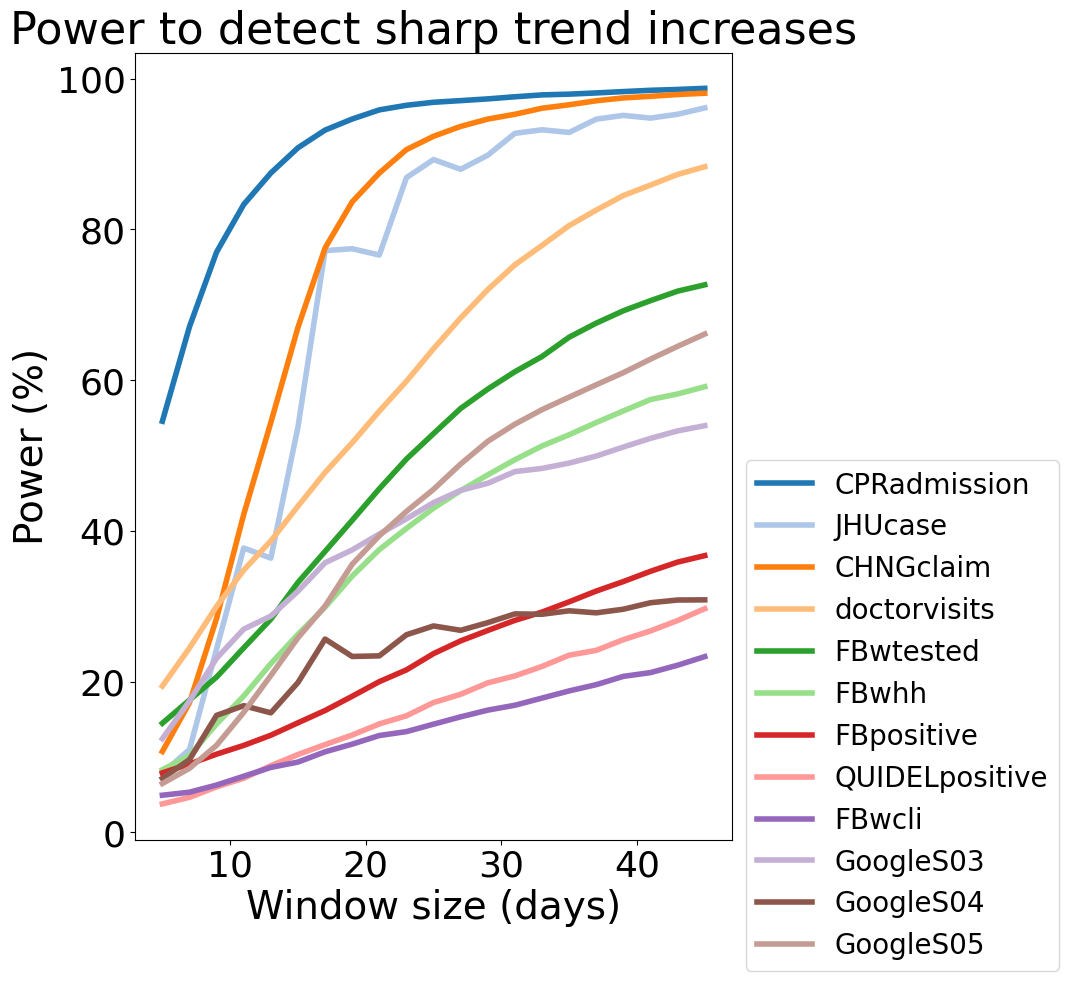

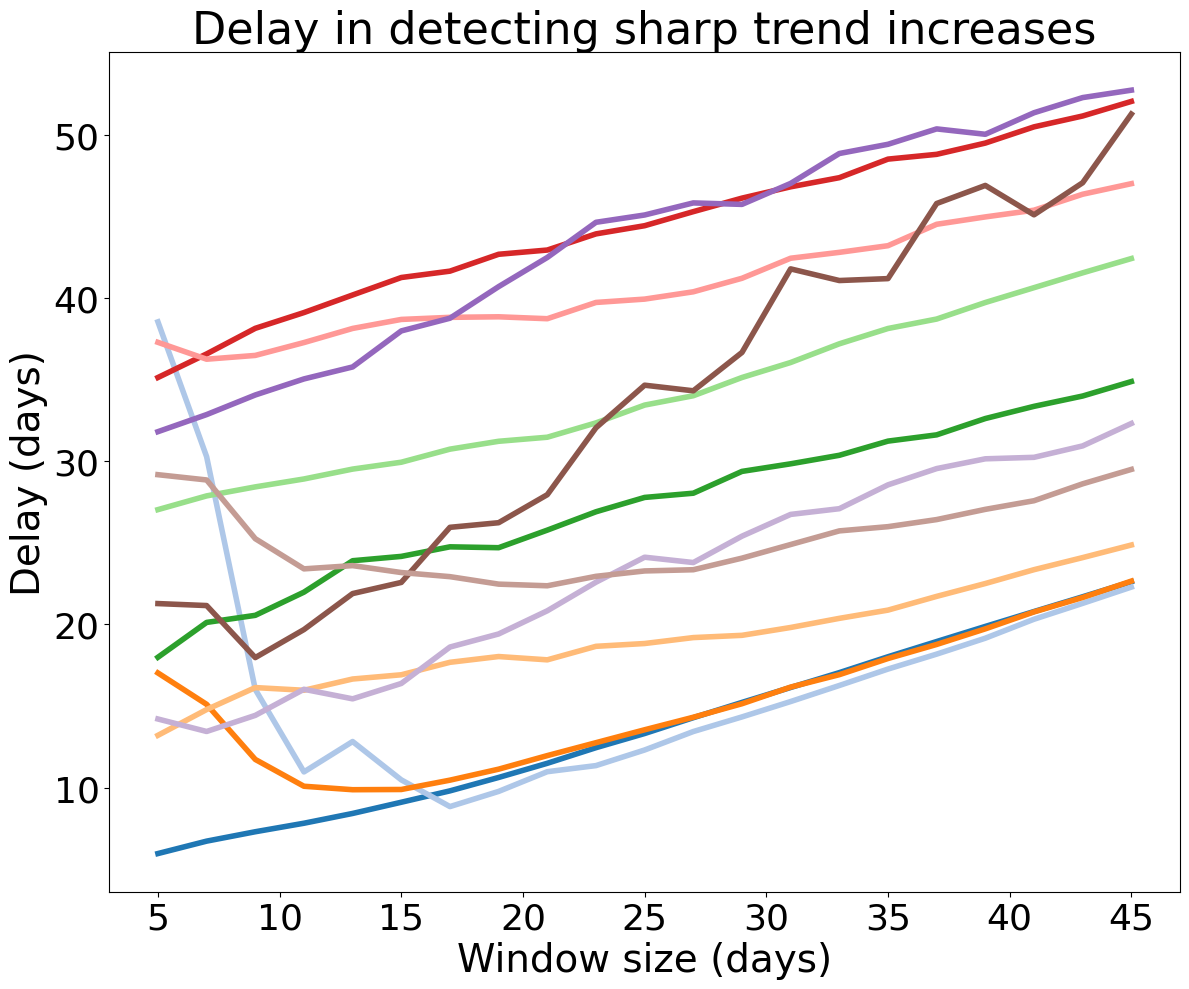

In [3]:
import matplotlib.pyplot as plt

# Plot settings
plt.rcParams.update({'xtick.labelsize': 26, 'ytick.labelsize': 26, 'axes.labelsize': 28})

# Streams to exclude
excluded_streams = {"CANpositivity", "FBwnohh", "GoogleS01","GoogleS02"}

# Assign tab20 colors to each stream
all_colors = plt.cm.tab20.colors
included_streams = [s for s in data.keys() if s not in excluded_streams]
color_map = {stream: all_colors[i % len(all_colors)] for i, stream in enumerate(included_streams)}

# --- Power Plot ---
plt.figure(figsize=(12, 10))
for stream in included_streams:
    values = data[stream]
    x = sorted(values.keys())
    y = [values[ws][0] for ws in x]  # Power
    plt.plot(x, y, label=stream, color=color_map[stream], linewidth=4)

plt.xlabel("Window size (days)")
plt.ylabel("Power (%)")
plt.title("Power to detect sharp trend increases", fontsize=32)
plt.legend(fontsize=20, loc='best', bbox_to_anchor=(1.0, 0.0, 0.5, 0.5))
plt.grid(False)
plt.tight_layout()
plt.savefig('gt_1_uni_power.png', dpi=300)
plt.show()

# --- Delay Plot ---
plt.figure(figsize=(12, 10))
for stream in included_streams:
    values = data[stream]
    x = sorted(values.keys())
    y = [values[ws][1] + 0.5 * (ws - 1) for ws in x]  # Adjusted Delay
    plt.plot(x, y, label=stream, color=color_map[stream], linewidth=4)

plt.xlabel("Window size (days)")
plt.ylabel("Delay (days)")
plt.title("Delay in detecting sharp trend increases", fontsize=32)
# plt.legend()  # Optional
plt.grid(False)
plt.tight_layout()
plt.savefig('gt_1_uni_delay.png', dpi=300)
plt.show()


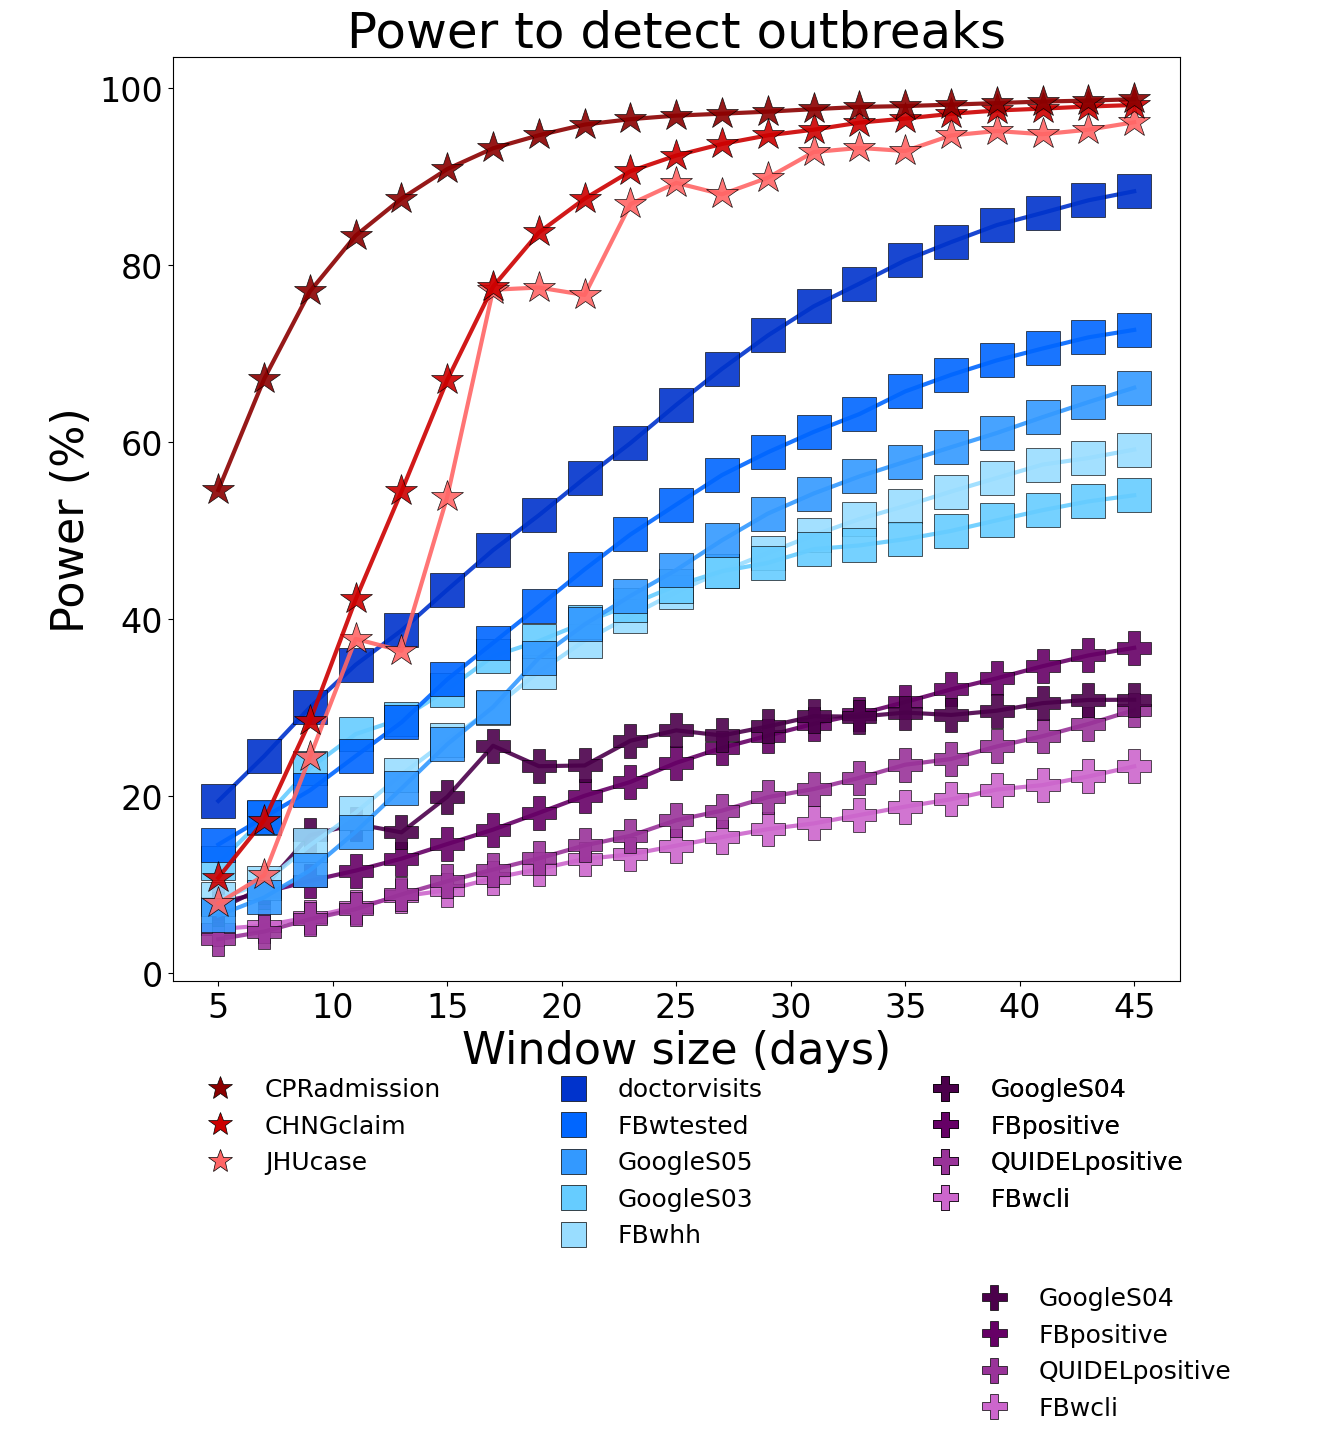

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------  stream groups (no Stolerman)  ------------------------
gt_streams     = ['CPRadmission', 'JHUcase', 'CHNGclaim']                         # 3
medium_streams = ['doctorvisits', 'GoogleS03', 'FBwtested', 'FBwhh', 'GoogleS05'] # 5
weak_streams   = ['FBpositive', 'QUIDELpositive', 'FBwcli', 'GoogleS04']          # 4

# ---------------------  colour palettes (dark → light)  ----------------------
red_shades    = ['#8b0000', '#cc0000', '#ff6666']                   # GT (3)
blue_shades   = ['#0033cc', '#0066ff', '#3399ff', '#66ccff', '#99ddff']  # Medium (5)
purple_shades = ['#4b004b', '#660066', '#993399', '#cc66cc']        # Weak (4)

# ---------------------  marker style dict  -----------------------------------
marker_map = {}
marker_map.update({s: '*' for s in gt_streams})       # stars
marker_map.update({s: 's' for s in medium_streams})   # squares
marker_map.update({s: 'P' for s in weak_streams})     # thick plus

# ---------------------  compute AUC for ordering & colours  ------------------
def auc(x, y):
    return float(np.trapz(y, x))

auc_map = {}
for stream in gt_streams + medium_streams + weak_streams:
    xs = sorted(data[stream].keys())
    ys = [data[stream][w][0] for w in xs]  # power from (power, delay)
    auc_map[stream] = auc(xs, ys)

# order within each group by descending AUC
gt_sorted     = sorted(gt_streams,     key=lambda s: -auc_map[s])
medium_sorted = sorted(medium_streams, key=lambda s: -auc_map[s])
weak_sorted   = sorted(weak_streams,   key=lambda s: -auc_map[s])

# assign colours based on rank
color_map = {}
for s, c in zip(gt_sorted,     red_shades):    color_map[s] = c
for s, c in zip(medium_sorted, blue_shades):   color_map[s] = c
for s, c in zip(weak_sorted,   purple_shades): color_map[s] = c

# final plotting order
streams_order = gt_sorted + medium_sorted + weak_sorted

# ---------------------  labels  ---------------------------------------------
label_map = {s: s for s in streams_order}

# ---------------------  plotting style  -------------------------------------
plt.rcParams.update({'xtick.labelsize': 24,
                     'ytick.labelsize': 24,
                     'axes.labelsize': 26})

# -------------------------------  POWER plot  --------------------------------
plt.figure(figsize=(13, 12))

for stream in reversed(streams_order):
    xs = sorted(data[stream].keys())
    ys = [data[stream][w][0] for w in xs]  # power from (power, delay)
    plt.plot(
        xs, ys,
        linestyle       = '-',
        linewidth       = 3,
        marker          = marker_map[stream],
        markersize      = 24,
        markerfacecolor = color_map[stream],
        markeredgecolor = 'black',
        markeredgewidth = 0.5,
        color           = color_map[stream],
        alpha           = 0.9,
        label           = label_map[stream]
    )

plt.xlabel("Window size (days)", fontsize=32)
plt.ylabel("Power (%)", fontsize=32)
plt.title("Power to detect outbreaks", fontsize=36)
plt.grid(False)

# ---------------------  three stacked legends (3 | 5 | 4)  -------------------
ax = plt.gca()

# 1st legend: GT (3 lines)
gt_handles = [
    plt.Line2D([], [], linestyle='', marker=marker_map[s],
               markersize=18, markerfacecolor=color_map[s],
               markeredgecolor='black', markeredgewidth=0.5,
               label=s)
    for s in gt_sorted
]
leg1 = ax.legend(
    gt_handles, gt_sorted,
    fontsize=18, loc='upper left',
    bbox_to_anchor=(0.00, -0.08),
    frameon=False
)
ax.add_artist(leg1)

# 2nd legend: Medium (5 lines)
med_handles = [
    plt.Line2D([], [], linestyle='', marker=marker_map[s],
               markersize=18, markerfacecolor=color_map[s],
               markeredgecolor='black', markeredgewidth=0.5,
               label=s)
    for s in medium_sorted
]
leg2 = ax.legend(
    med_handles, medium_sorted,
    fontsize=18, loc='upper left',
    bbox_to_anchor=(0.35, -0.08),
    frameon=False
)
ax.add_artist(leg2)

# 3rd legend: Weak (4 lines)
weak_handles = [
    plt.Line2D([], [], linestyle='', marker=marker_map[s],
               markersize=18, markerfacecolor=color_map[s],
               markeredgecolor='black', markeredgewidth=0.5,
               label=s)
    for s in weak_sorted
]
leg3 = ax.legend(
    weak_handles, weak_sorted,
    fontsize=18, loc='upper left',
    bbox_to_anchor=(0.72, -0.08),
    frameon=False
)
ax.add_artist(leg3)

# Existing main plot
fig = plt.gcf()
ax = plt.gca()

# Create a new invisible axis below the current one
legend_ax = fig.add_axes([0, -0.25, 1, 0.1])  # [left, bottom, width, height]
legend_ax.axis('off')  # Hide this axis completely

# Plot the three legends in that new space
legend_ax.legend(gt_handles, gt_sorted,
                 fontsize=18, loc='center left', bbox_to_anchor=(0.00, 0.5), frameon=False)

legend_ax.legend(med_handles, medium_sorted,
                 fontsize=18, loc='center left', bbox_to_anchor=(0.35, 0.5), frameon=False)

legend_ax.legend(weak_handles, weak_sorted,
                 fontsize=18, loc='center left', bbox_to_anchor=(0.72, 0.5), frameon=False)

#plt.tight_layout()
plt.savefig("power_all_gt.png", dpi=300, bbox_inches='tight')
plt.show()


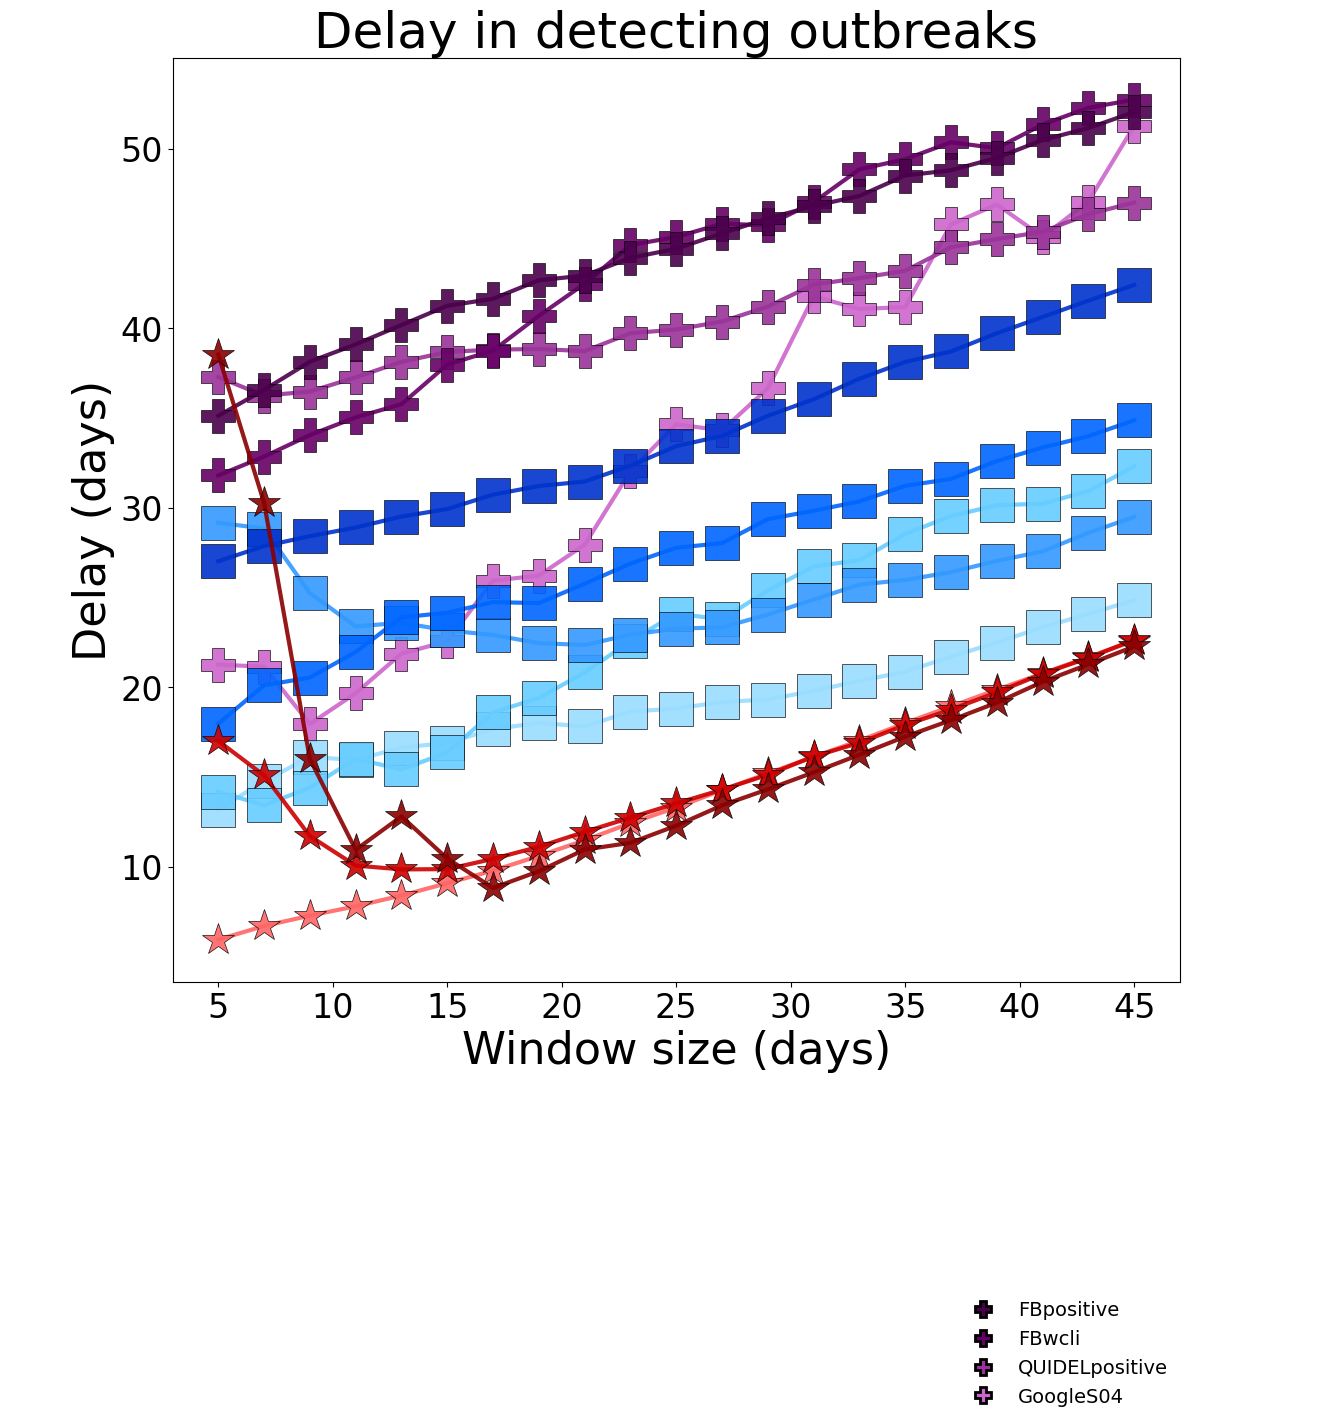

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------  stream groups (no Stolerman)  ------------------------
gt_streams     = ['CPRadmission', 'JHUcase', 'CHNGclaim']                          # 3
medium_streams = ['doctorvisits', 'GoogleS03', 'FBwtested', 'FBwhh', 'GoogleS05']  # 5
weak_streams   = ['FBpositive', 'QUIDELpositive', 'FBwcli', 'GoogleS04']           # 4

# ---------------------  colour palettes (dark → light)  ----------------------
red_shades    = ['#8b0000', '#cc0000', '#ff6666']                                  # GT
blue_shades   = ['#0033cc', '#0066ff', '#3399ff', '#66ccff', '#99ddff']            # Medium
purple_shades = ['#4b004b', '#660066', '#993399', '#cc66cc']                       # Weak

# ---------------------  marker style dict  -----------------------------------
marker_map = {}
marker_map.update({s: '*' for s in gt_streams})        # stars
marker_map.update({s: 's' for s in medium_streams})    # squares
marker_map.update({s: 'P' for s in weak_streams})      # thick plus

# ---------------------  compute AUC for ordering & colours  ------------------
def auc(x, y):
    return float(np.trapz(y, x))

auc_map = {}
for stream in gt_streams + medium_streams + weak_streams:
    xs = sorted(data[stream].keys())
    ys = [data[stream][w][1] + 0.5*(w-1) for w in xs]   # adjusted delay from (power, delay)
    auc_map[stream] = auc(xs, ys)

# Order within each group by descending AUC
gt_sorted     = sorted(gt_streams,     key=lambda s: -auc_map[s])
medium_sorted = sorted(medium_streams, key=lambda s: -auc_map[s])
weak_sorted   = sorted(weak_streams,   key=lambda s: -auc_map[s])

# Assign colours based on rank
color_map = {}
for s, c in zip(gt_sorted,     red_shades):    color_map[s] = c
for s, c in zip(medium_sorted, blue_shades):   color_map[s] = c
for s, c in zip(weak_sorted,   purple_shades): color_map[s] = c

streams_order = gt_sorted + medium_sorted + weak_sorted
label_map     = {s: s for s in streams_order}

# ---------------------  plotting style  --------------------------------------
plt.rcParams.update({'xtick.labelsize': 24,
                     'ytick.labelsize': 24,
                     'axes.labelsize': 26})

# -------------------------------  DELAY plot  --------------------------------
plt.figure(figsize=(13, 12))

for stream in reversed(streams_order):
    xs = sorted(data[stream].keys())
    ys = [data[stream][w][1] + 0.5*(w-1) for w in xs]   # adjusted delay from (power, delay)
    plt.plot(
        xs, ys,
        linestyle       = '-',
        linewidth       = 3,
        marker          = marker_map[stream],
        markersize      = 24,
        markerfacecolor = color_map[stream],
        markeredgecolor = 'black',
        markeredgewidth = 0.5,
        color           = color_map[stream],
        alpha           = 0.9,
        label           = label_map[stream]
    )

plt.xlabel("Window size (days)", fontsize=32)
plt.ylabel("Delay (days)", fontsize=32)
plt.title("Delay in detecting outbreaks", fontsize=36)
plt.grid(False)

# ---------------------  three stacked legends (3 | 5 | 4)  -------------------
ax = plt.gca()

# GT handles
gt_handles = [plt.Line2D([], [], linestyle='', marker=marker_map[s],
                         markersize=12, markerfacecolor=color_map[s],
                         markeredgecolor='black', markeredgewidth=2, label=s)
              for s in gt_sorted]

# Medium handles
med_handles = [plt.Line2D([], [], linestyle='', marker=marker_map[s],
                          markersize=12, markerfacecolor=color_map[s],
                          markeredgecolor='black', markeredgewidth=2, label=s)
               for s in medium_sorted]

# Weak handles
weak_handles = [plt.Line2D([], [], linestyle='', marker=marker_map[s],
                           markersize=12, markerfacecolor=color_map[s],
                           markeredgecolor='black', markeredgewidth=2, label=s)
                for s in weak_sorted]

# Create invisible axis just for legends
fig = plt.gcf()
legend_ax = fig.add_axes([0, -0.25, 1, 0.1])   # [left, bottom, width, height]
legend_ax.axis('off')

legend_ax.legend(gt_handles, gt_sorted,
                 fontsize=14, loc='center left',
                 bbox_to_anchor=(0.00, 0.5), frameon=False)

legend_ax.legend(med_handles, medium_sorted,
                 fontsize=14, loc='center left',
                 bbox_to_anchor=(0.35, 0.5), frameon=False)

legend_ax.legend(weak_handles, weak_sorted,
                 fontsize=14, loc='center left',
                 bbox_to_anchor=(0.72, 0.5), frameon=False)

# Save with full legend
plt.savefig("delay_all_gt.png", dpi=300, bbox_inches='tight')
plt.show()


### MULTIVARIATE

In [32]:
import re

filename = "../meta_full_3gt_84.txt"
data = {}
alpha = None
current_window = None

with open(filename) as f:
    for raw in f:
        line = raw.strip()
        if not line:
            continue

        # alpha line
        m = re.match(r"alpha\s*=\s*([\d.]+)%", line)
        if m:
            alpha = float(m.group(1))
            continue

        # window size
        m = re.match(r"Window size\s+(\d+)", line, flags=re.IGNORECASE)
        if m:
            current_window = int(m.group(1))
            continue

        # stream line: power, (pthr or cnt_thr), delay
        m = re.match(
            r"([^,]+),\s*power\s*=\s*([\d.]+)%,"            # stream, power
            r"\s*(?:pthr|cnt_thr)\s*=\s*([\d.]+),"          # either pthr or cnt_thr
            r"\s*delay\s*([\d.]+)\s*days",                  # delay
            line
        )
        if m and current_window is not None:
            stream = m.group(1)
            power  = float(m.group(2))
            thr    = float(m.group(3))
            delay  = float(m.group(4))
            data.setdefault(stream, {})[current_window] = {
                "power":   power,
                # you can store this under a unified key if you like:
                "threshold": thr,
                "delay":   delay
            }
            continue

        # else: unrecognized line, ignore


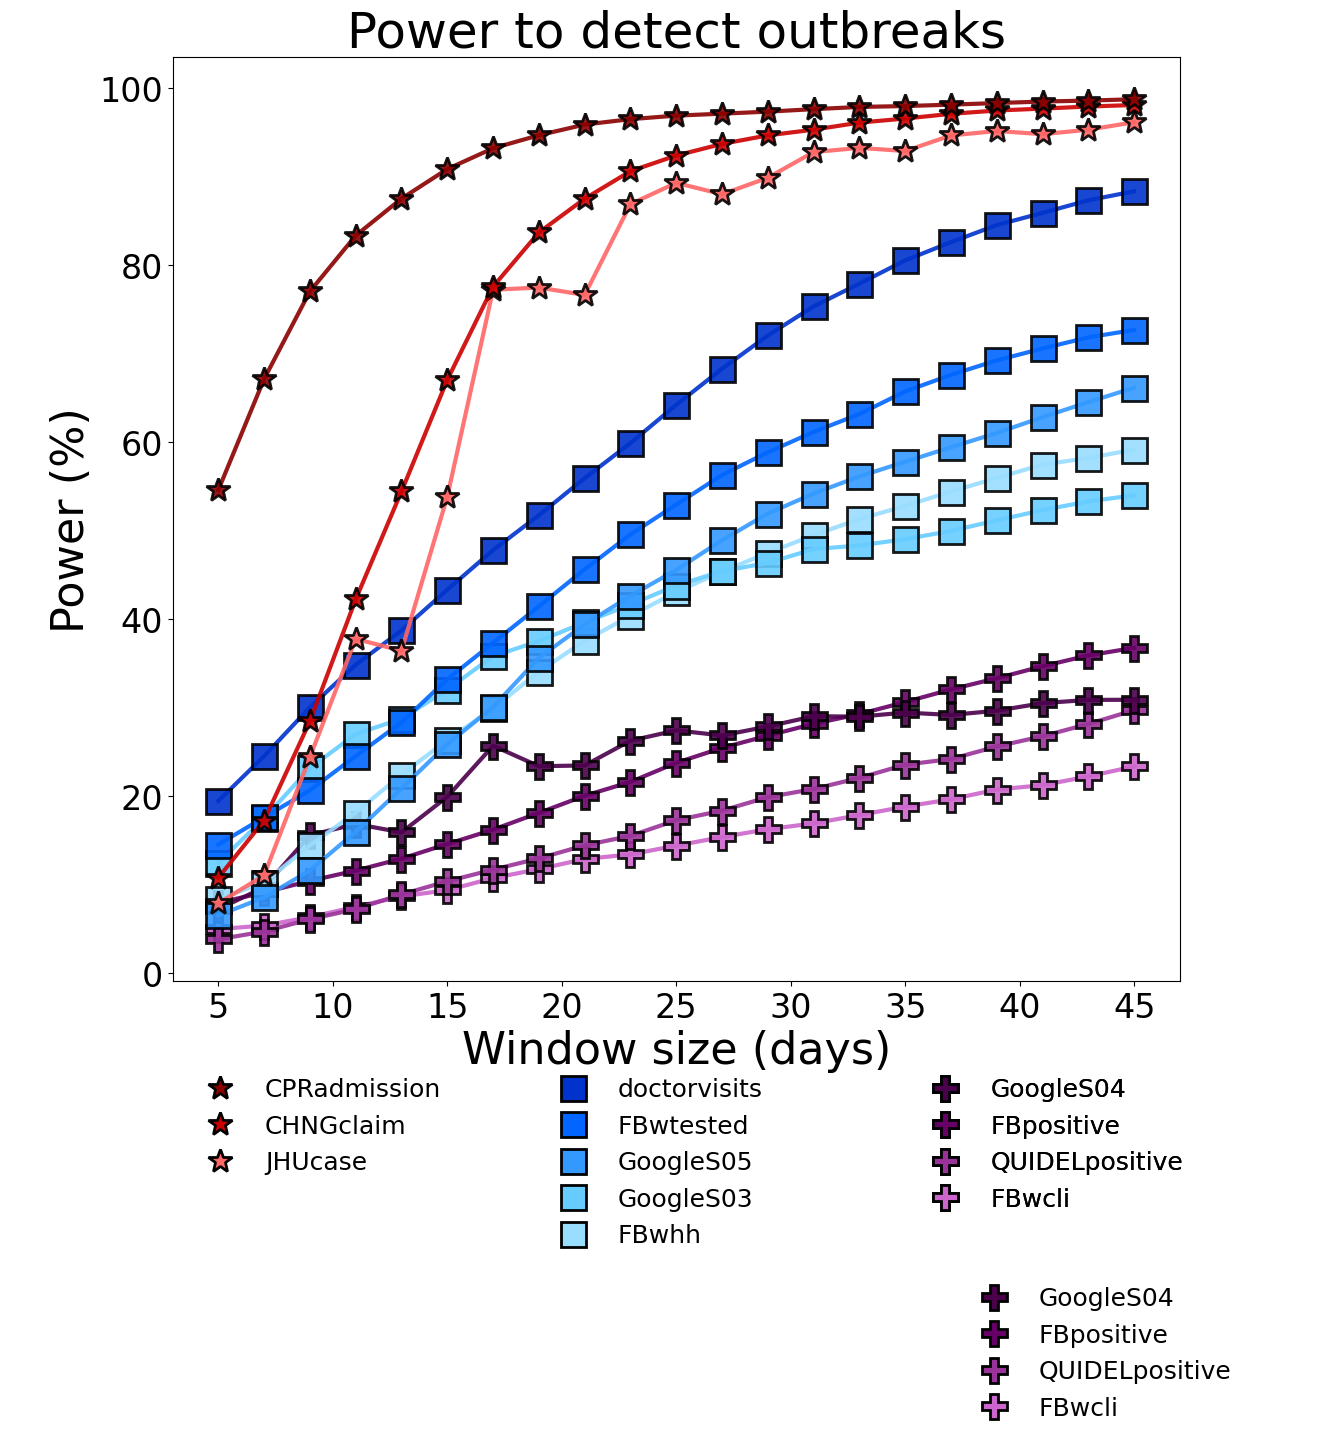

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------  stream groups (no Stolerman)  ------------------------
gt_streams     = ['CPRadmission', 'JHUcase', 'CHNGclaim']                         # 3
medium_streams = ['doctorvisits', 'GoogleS03', 'FBwtested', 'FBwhh', 'GoogleS05'] # 5
weak_streams   = ['FBpositive', 'QUIDELpositive', 'FBwcli', 'GoogleS04']          # 4

# ---------------------  colour palettes (dark → light)  ----------------------
red_shades    = ['#8b0000', '#cc0000', '#ff6666']                   # GT (3)
blue_shades   = ['#0033cc', '#0066ff', '#3399ff', '#66ccff', '#99ddff']  # Medium (5)
purple_shades = ['#4b004b', '#660066', '#993399', '#cc66cc']        # Weak (4)

# ---------------------  marker style dict  -----------------------------------
marker_map = {}
marker_map.update({s: '*' for s in gt_streams})       # stars
marker_map.update({s: 's' for s in medium_streams})   # squares
marker_map.update({s: 'P' for s in weak_streams})     # thick plus

# ---------------------  compute AUC for ordering & colours  ------------------
def auc(x, y):
    return float(np.trapz(y, x))

auc_map = {}
for stream in gt_streams + medium_streams + weak_streams:
    xs = sorted(data[stream].keys())
    ys = [data[stream][w]['power'] for w in xs]
    auc_map[stream] = auc(xs, ys)

# order within each group by descending AUC
gt_sorted     = sorted(gt_streams,     key=lambda s: -auc_map[s])
medium_sorted = sorted(medium_streams, key=lambda s: -auc_map[s])
weak_sorted   = sorted(weak_streams,   key=lambda s: -auc_map[s])

# assign colours based on rank
color_map = {}
for s, c in zip(gt_sorted,     red_shades):    color_map[s] = c
for s, c in zip(medium_sorted, blue_shades):   color_map[s] = c
for s, c in zip(weak_sorted,   purple_shades): color_map[s] = c

# final plotting order
streams_order = gt_sorted + medium_sorted + weak_sorted

# ---------------------  labels  ---------------------------------------------
label_map = {s: s for s in streams_order}

# ---------------------  plotting style  -------------------------------------
plt.rcParams.update({'xtick.labelsize': 24,
                     'ytick.labelsize': 24,
                     'axes.labelsize': 26})

# -------------------------------  plot  --------------------------------------
plt.figure(figsize=(13, 12))

for stream in reversed(streams_order):
    xs = sorted(data[stream].keys())
    ys = [data[stream][w]['power'] for w in xs]
    plt.plot(
        xs, ys,
        linestyle       = '-',
        linewidth       = 3,
        marker          = marker_map[stream],
        markersize      = 18,
        markerfacecolor = color_map[stream],
        markeredgecolor = 'black',
        markeredgewidth = 2.0,
        color           = color_map[stream],
        alpha           = 0.9,
        label           = label_map[stream]
    )

plt.xlabel("Window size (days)", fontsize=32)
plt.ylabel("Power (%)", fontsize=32)
plt.title("Power to detect outbreaks", fontsize=36)
plt.grid(False)

# ---------------------  three stacked legends (3 | 5 | 4)  -------------------
# ---------------------  three stacked legends (3 | 5 | 4)  -------------------
ax = plt.gca()

# 1st legend: GT (3 lines)
gt_handles = [
    plt.Line2D([], [], linestyle='', marker=marker_map[s],
               markersize=18, markerfacecolor=color_map[s],
               markeredgecolor='black', markeredgewidth=2,
               label=s)
    for s in gt_sorted
]
leg1 = ax.legend(
    gt_handles, gt_sorted,
    fontsize=18, loc='upper left',
    bbox_to_anchor=(0.00, -0.08),
    frameon=False
)
ax.add_artist(leg1)

# 2nd legend: Medium (5 lines)
med_handles = [
    plt.Line2D([], [], linestyle='', marker=marker_map[s],
               markersize=18, markerfacecolor=color_map[s],
               markeredgecolor='black', markeredgewidth=2,
               label=s)
    for s in medium_sorted
]
leg2 = ax.legend(
    med_handles, medium_sorted,
    fontsize=18, loc='upper left',
    bbox_to_anchor=(0.35, -0.08),
    frameon=False
)
ax.add_artist(leg2)

# 3rd legend: Weak (4 lines)
weak_handles = [
    plt.Line2D([], [], linestyle='', marker=marker_map[s],
               markersize=18, markerfacecolor=color_map[s],
               markeredgecolor='black', markeredgewidth=2,
               label=s)
    for s in weak_sorted
]
leg3 = ax.legend(
    weak_handles, weak_sorted,
    fontsize=18, loc='upper left',
    bbox_to_anchor=(0.72, -0.08),
    frameon=False
)
ax.add_artist(leg3)

# Existing main plot
fig = plt.gcf()
ax = plt.gca()

# Create a new invisible axis below the current one
legend_ax = fig.add_axes([0, -0.25, 1, 0.1])  # [left, bottom, width, height]
legend_ax.axis('off')  # Hide this axis completely

# Plot the three legends in that new space
legend_ax.legend(gt_handles, gt_sorted,
                 fontsize=18, loc='center left', bbox_to_anchor=(0.00, 0.5), frameon=False)

legend_ax.legend(med_handles, medium_sorted,
                 fontsize=18, loc='center left', bbox_to_anchor=(0.35, 0.5), frameon=False)

legend_ax.legend(weak_handles, weak_sorted,
                 fontsize=18, loc='center left', bbox_to_anchor=(0.72, 0.5), frameon=False)


#plt.tight_layout()
plt.savefig("grouped_power_gt_med_weak_AUC.png", dpi=300, bbox_inches='tight')
plt.show()


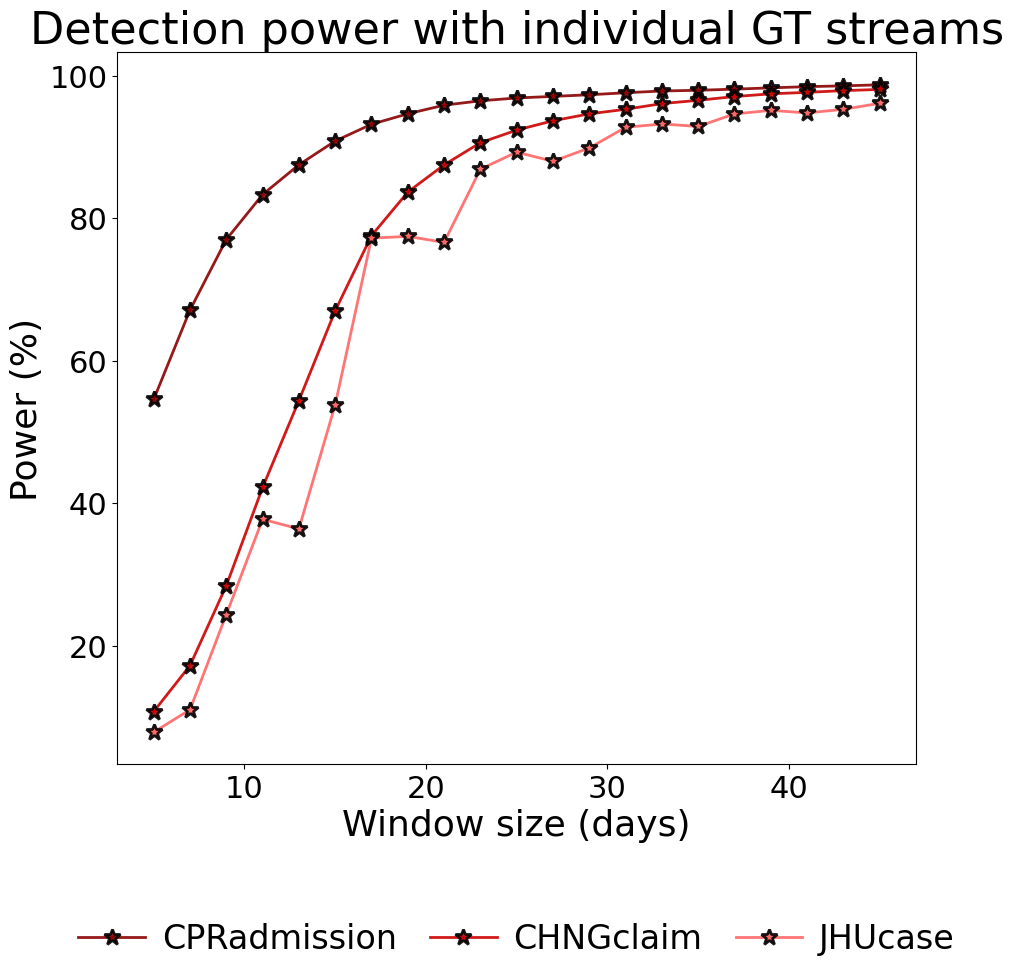

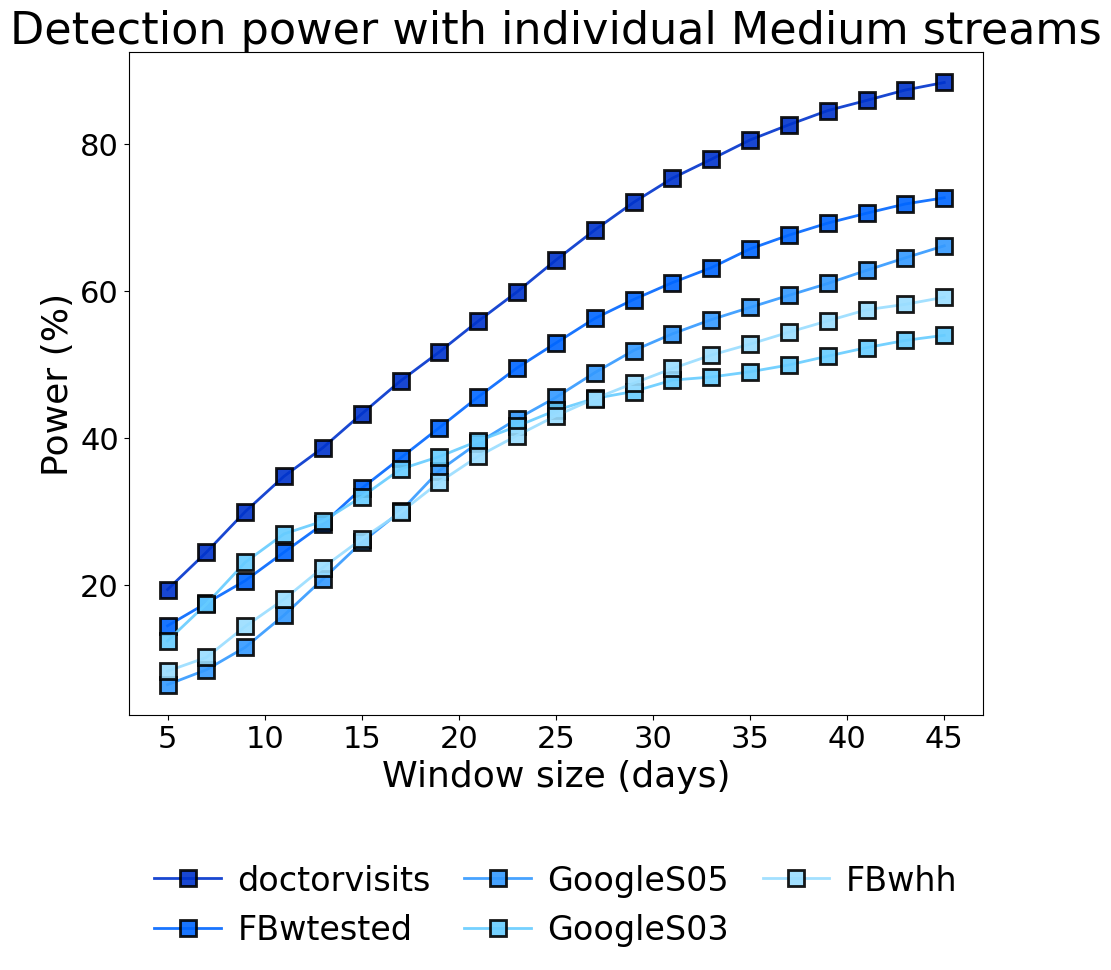

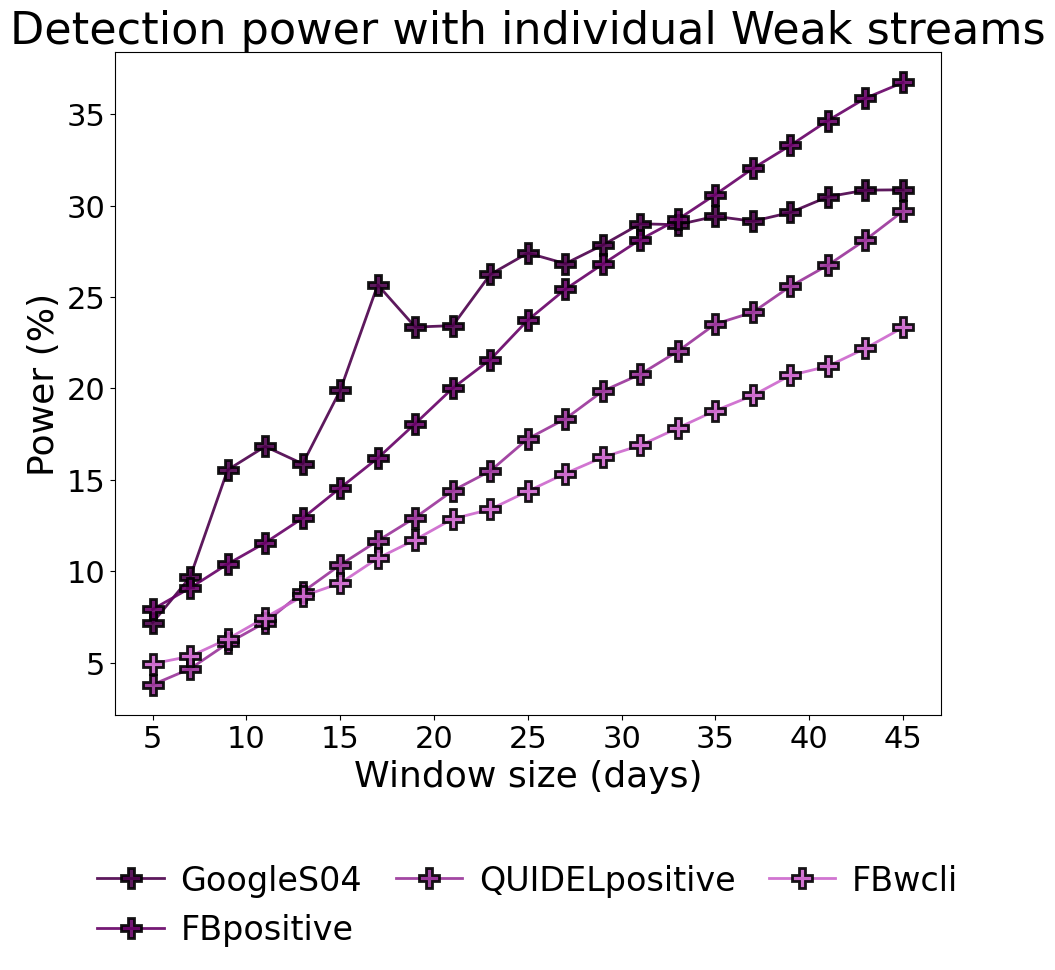

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------  stream groups (no Stolerman)  ------------------------
gt_streams      = ['CPRadmission', 'JHUcase', 'CHNGclaim']                         # 3
medium_streams  = ['doctorvisits', 'GoogleS03', 'FBwtested', 'FBwhh', 'GoogleS05'] # 5
weak_streams    = ['FBpositive', 'QUIDELpositive', 'FBwcli', 'GoogleS04']           # 4

group_defs = {
    'GT': {
        'streams': gt_streams,
        'shades': ['#8b0000', '#cc0000', '#ff6666'],      # dark → light
        'marker': '*',
        'marker_size': 12
    },
    'Medium': {
        'streams': medium_streams,
        'shades': ['#0033cc', '#0066ff', '#3399ff', '#66ccff', '#99ddff'],
        'marker': 's',
        'marker_size': 12
    },
    'Weak': {
        'streams': weak_streams,
        'shades': ['#4b004b', '#660066', '#993399', '#cc66cc'],
        'marker': 'P',
        'marker_size': 14  # as in original larger for weak
    }
}

# ---------------------  compute AUC for ordering & colours  ------------------
def auc(x, y):
    return float(np.trapz(y, x))

auc_map = {}
for stream in gt_streams + medium_streams + weak_streams:
    xs = sorted(data[stream].keys())
    ys = [data[stream][w]['power'] for w in xs]
    auc_map[stream] = auc(xs, ys)

# sort within each group by descending AUC and assign colors
for group_name, info in group_defs.items():
    streams = info['streams']
    sorted_streams = sorted(streams, key=lambda s: -auc_map[s])
    info['sorted_streams'] = sorted_streams
    color_map = {}
    for s, c in zip(sorted_streams, info['shades']):
        color_map[s] = c
    info['color_map'] = color_map

# ---------------------  plotting style  -------------------------------------
plt.rcParams.update({'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'axes.labelsize': 18})

# ---------------------  function to plot a group -----------------------------
def plot_group(group_name, info):
    streams = info['sorted_streams']
    color_map = info['color_map']
    marker = info['marker']
    base_marker_size = info['marker_size']

    fig, ax = plt.subplots(figsize=(10, 10))
    for stream in streams:
        xs = sorted(data[stream].keys())
        ys = [data[stream][w]['power'] for w in xs]
        ax.plot(
            xs, ys,
            linestyle='-',
            linewidth=2,
            marker=marker,
            markersize=base_marker_size,
            markerfacecolor=color_map[stream],
            markeredgecolor='black',
            markeredgewidth=2.0,
            color=color_map[stream],
            alpha=0.9,
            label=stream
        )
    ax.tick_params(axis='both', labelsize=22)

    ax.set_xlabel("Window size (days)", fontsize=26)
    ax.set_ylabel("Power (%)", fontsize=26)
    ax.set_title(f"Detection power with individual {group_name} streams", fontsize=32)
    ax.grid(False)

    # Legend below the plot with 3 columns, wrapping if more entries
    legend = ax.legend(
        fontsize=24,
        ncol=3,
        frameon=False,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.18),
        handletextpad=0.5,
        columnspacing=1.0,
    )

    plt.tight_layout()
    fname = f"grouped_power_{group_name.lower()}_AUC.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    return fname


# ---------------------  make the three plots -------------------------------
filenames = []
for group_name, info in group_defs.items():
    fname = plot_group(group_name, info)
    filenames.append(fname)

# filenames contains the saved PNGs for GT, Medium, and Weak plots.


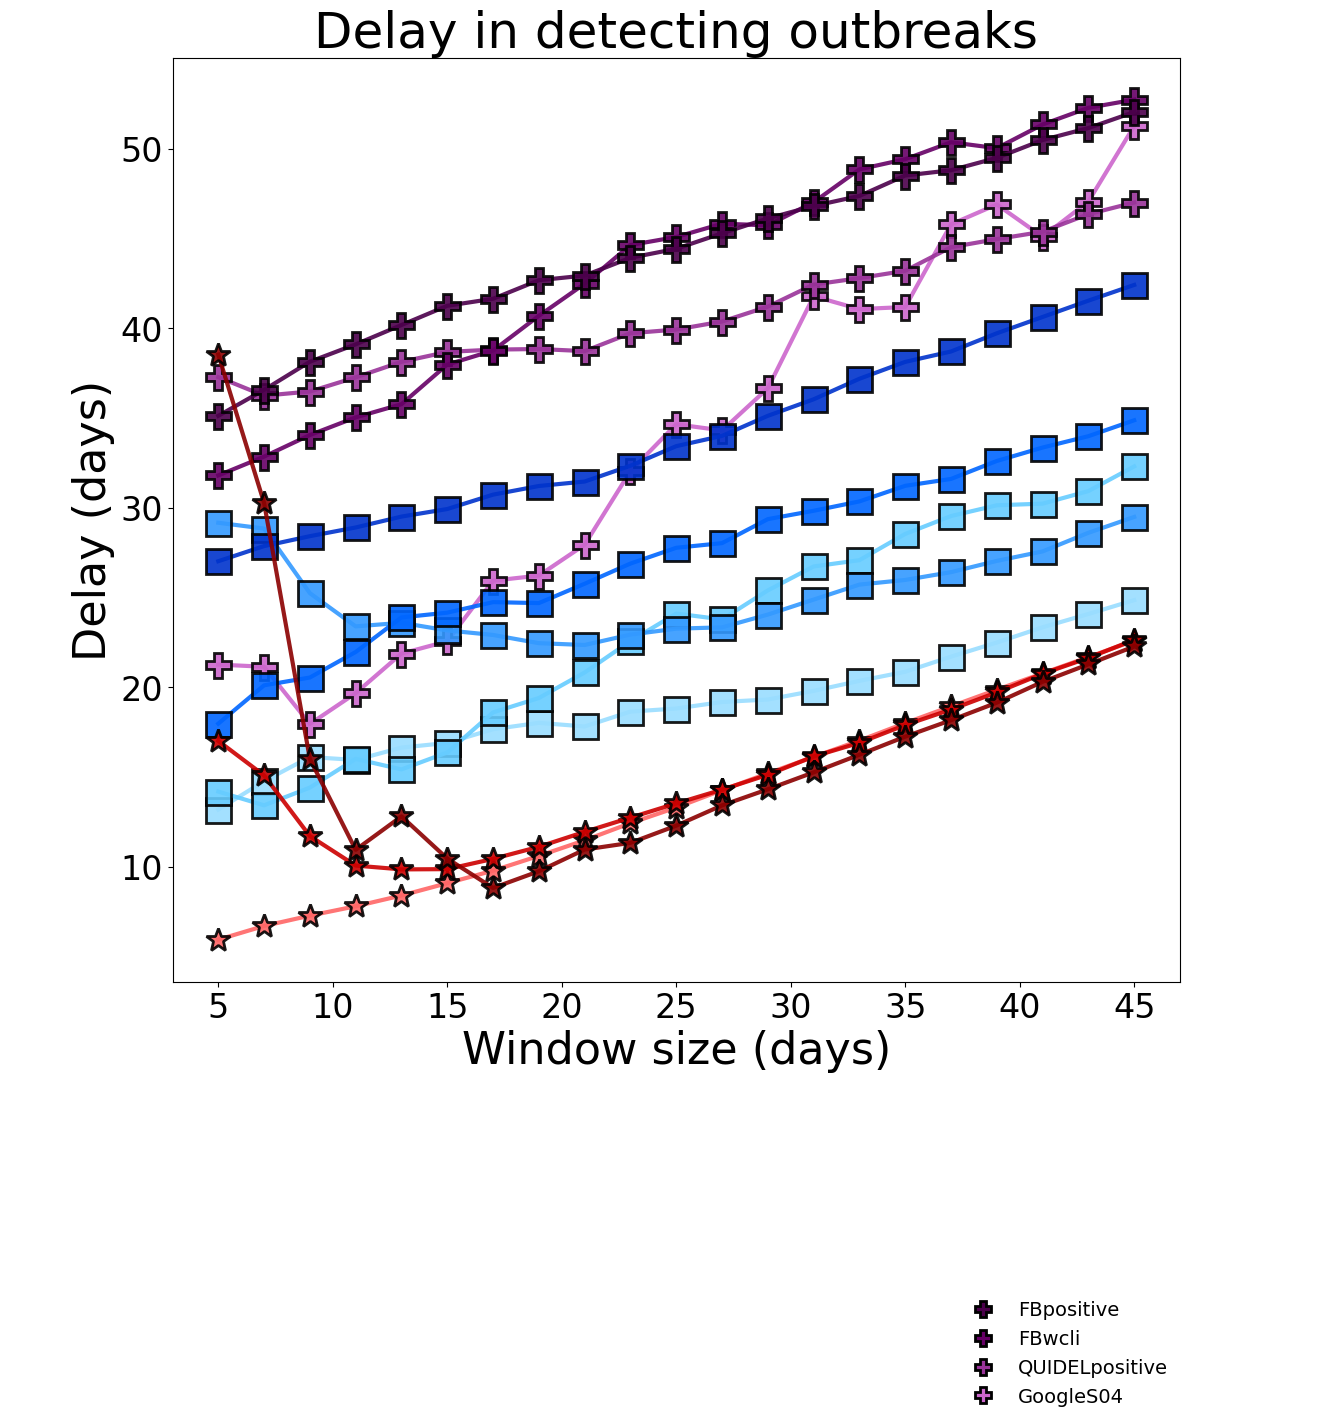

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------  stream groups (no Stolerman)  ------------------------
gt_streams     = ['CPRadmission', 'JHUcase', 'CHNGclaim']                          # 3
medium_streams = ['doctorvisits', 'GoogleS03', 'FBwtested', 'FBwhh', 'GoogleS05']  # 5
weak_streams   = ['FBpositive', 'QUIDELpositive', 'FBwcli', 'GoogleS04']           # 4

# ---------------------  colour palettes (dark → light)  ----------------------
red_shades    = ['#8b0000', '#cc0000', '#ff6666']                                  # GT
blue_shades   = ['#0033cc', '#0066ff', '#3399ff', '#66ccff', '#99ddff']            # Medium
purple_shades = ['#4b004b', '#660066', '#993399', '#cc66cc']                       # Weak

# ---------------------  marker style dict  -----------------------------------
marker_map = {}
marker_map.update({s: '*' for s in gt_streams})        # stars
marker_map.update({s: 's' for s in medium_streams})    # squares
marker_map.update({s: 'P' for s in weak_streams})      # thick plus

# ---------------------  compute AUC for ordering & colours  ------------------
def auc(x, y):
    return float(np.trapz(y, x))

auc_map = {}
for stream in gt_streams + medium_streams + weak_streams:
    xs = sorted(data[stream].keys())
    ys = [data[stream][w]['delay'] + 0.5*(w-1) for w in xs]   # adjusted delay
    auc_map[stream] = auc(xs, ys)

# Order within each group by descending AUC
gt_sorted     = sorted(gt_streams,     key=lambda s: -auc_map[s])
medium_sorted = sorted(medium_streams, key=lambda s: -auc_map[s])
weak_sorted   = sorted(weak_streams,   key=lambda s: -auc_map[s])

# Assign colours based on rank
color_map = {}
for s, c in zip(gt_sorted,     red_shades):    color_map[s] = c
for s, c in zip(medium_sorted, blue_shades):   color_map[s] = c
for s, c in zip(weak_sorted,   purple_shades): color_map[s] = c

streams_order = gt_sorted + medium_sorted + weak_sorted
label_map     = {s: s for s in streams_order}

# ---------------------  plotting style  --------------------------------------
plt.rcParams.update({'xtick.labelsize': 24,
                     'ytick.labelsize': 24,
                     'axes.labelsize': 26})

# -------------------------------  DELAY plot  --------------------------------
plt.figure(figsize=(13, 12))

for stream in reversed(streams_order):
    xs = sorted(data[stream].keys())
    ys = [data[stream][w]['delay'] + 0.5*(w-1) for w in xs]   # adjusted delay
    plt.plot(
        xs, ys,
        linestyle       = '-',
        linewidth       = 3,
        marker          = marker_map[stream],
        markersize      = 18,
        markerfacecolor = color_map[stream],
        markeredgecolor = 'black',
        markeredgewidth = 2.0,
        color           = color_map[stream],
        alpha           = 0.9,
        label           = label_map[stream]
    )

plt.xlabel("Window size (days)", fontsize=32)
plt.ylabel("Delay (days)", fontsize=32)
plt.title("Delay in detecting outbreaks", fontsize=36)
plt.grid(False)

# ---------------------  three stacked legends (3 | 5 | 4)  -------------------
ax = plt.gca()

# GT handles
gt_handles = [plt.Line2D([], [], linestyle='', marker=marker_map[s],
                         markersize=12, markerfacecolor=color_map[s],
                         markeredgecolor='black', markeredgewidth=2, label=s)
              for s in gt_sorted]

# Medium handles
med_handles = [plt.Line2D([], [], linestyle='', marker=marker_map[s],
                          markersize=12, markerfacecolor=color_map[s],
                          markeredgecolor='black', markeredgewidth=2, label=s)
               for s in medium_sorted]

# Weak handles
weak_handles = [plt.Line2D([], [], linestyle='', marker=marker_map[s],
                           markersize=12, markerfacecolor=color_map[s],
                           markeredgecolor='black', markeredgewidth=2, label=s)
                for s in weak_sorted]

# Create invisible axis just for legends
fig = plt.gcf()
legend_ax = fig.add_axes([0, -0.25, 1, 0.1])   # [left, bottom, width, height]
legend_ax.axis('off')

legend_ax.legend(gt_handles, gt_sorted,
                 fontsize=14, loc='center left',
                 bbox_to_anchor=(0.00, 0.5), frameon=False)

legend_ax.legend(med_handles, medium_sorted,
                 fontsize=14, loc='center left',
                 bbox_to_anchor=(0.35, 0.5), frameon=False)

legend_ax.legend(weak_handles, weak_sorted,
                 fontsize=14, loc='center left',
                 bbox_to_anchor=(0.72, 0.5), frameon=False)

# Save with full legend
plt.savefig("grouped_delay_gt_med_weak_AUC.png", dpi=300, bbox_inches='tight')
plt.show()


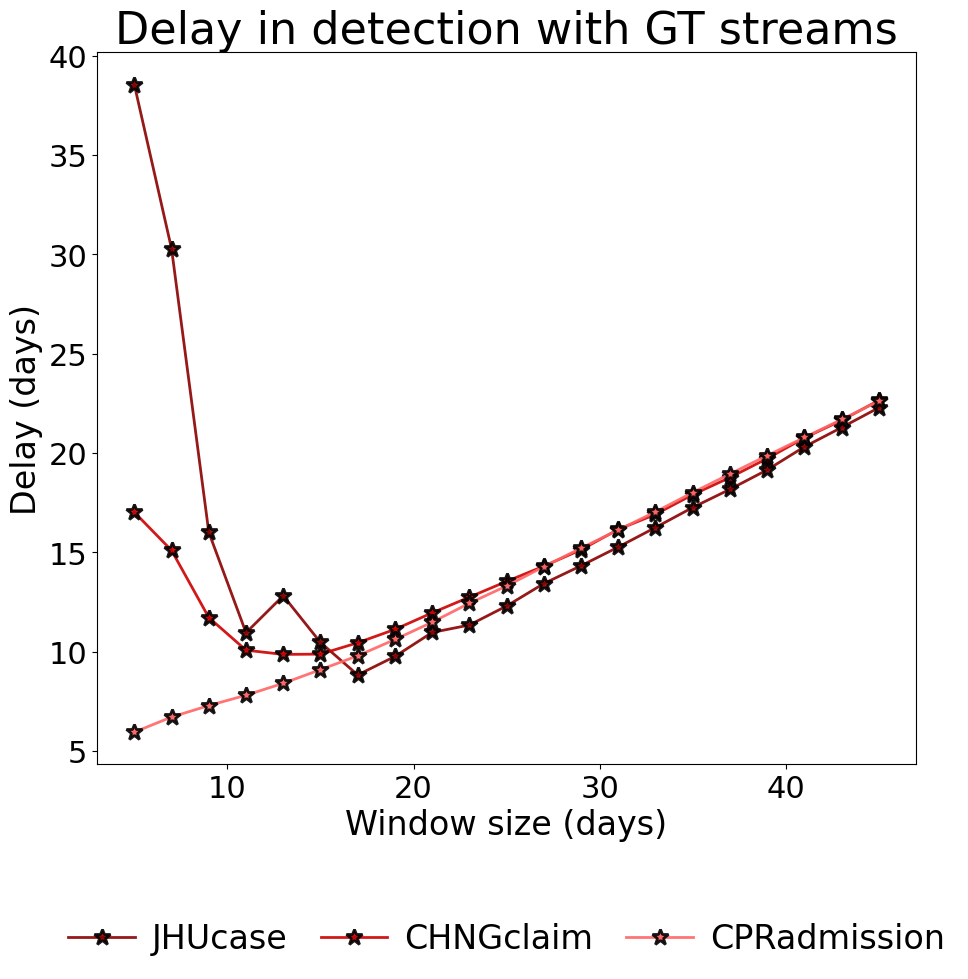

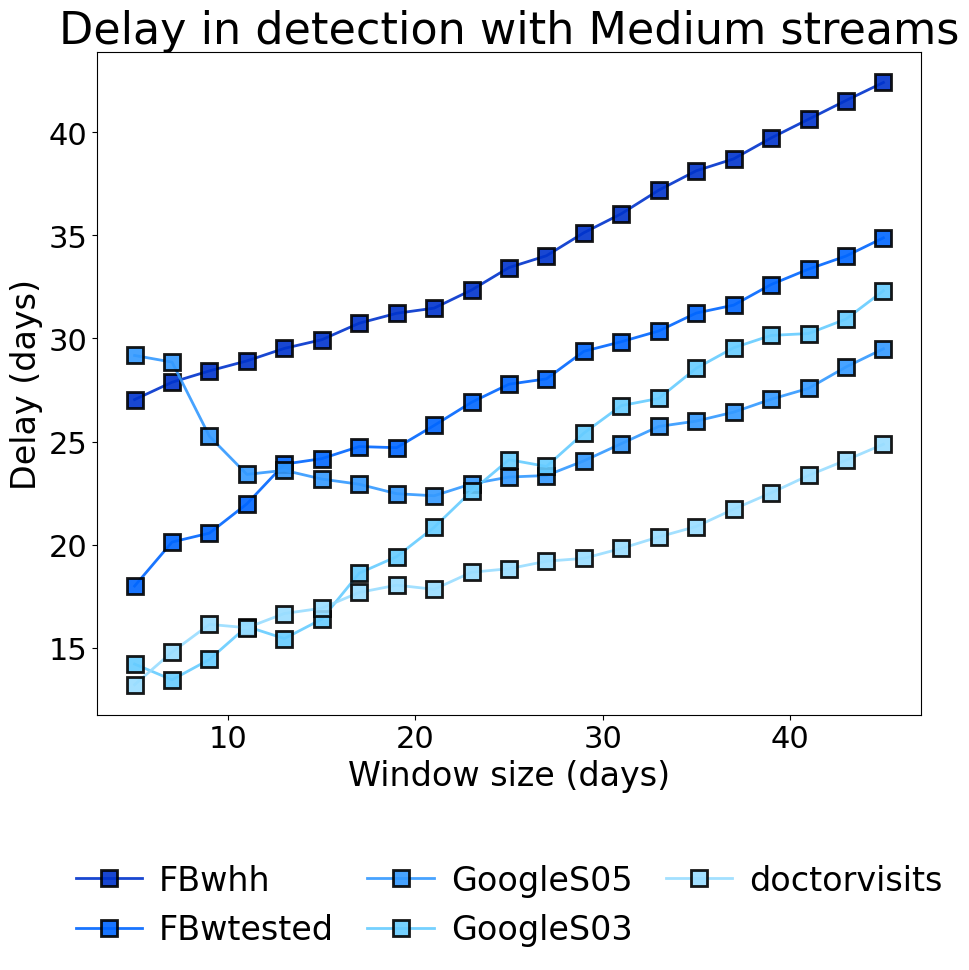

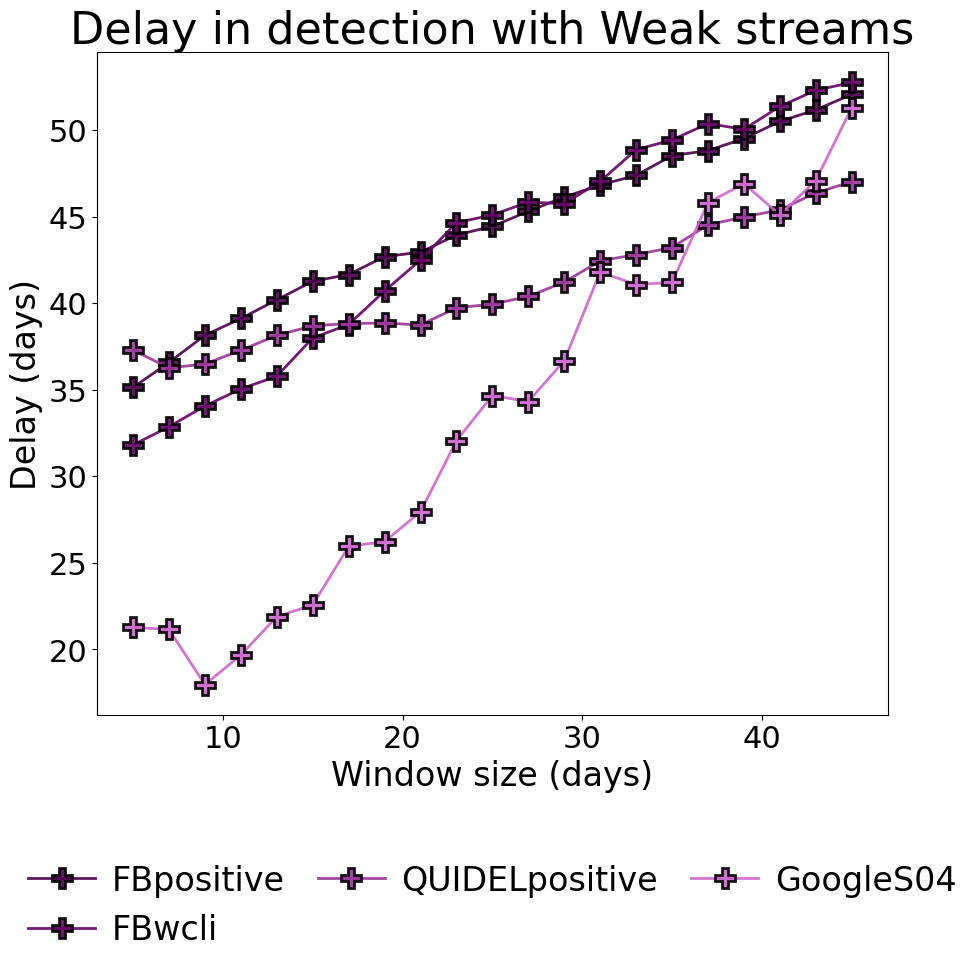

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------  stream groups (no Stolerman)  ------------------------
gt_streams      = ['CPRadmission', 'JHUcase', 'CHNGclaim']                          # 3
medium_streams  = ['doctorvisits', 'GoogleS03', 'FBwtested', 'FBwhh', 'GoogleS05']  # 5
weak_streams    = ['FBpositive', 'QUIDELpositive', 'FBwcli', 'GoogleS04']           # 4

# ---------------------  group definitions ------------------------------------
group_defs = {
    'GT': {
        'streams': gt_streams,
        'shades': ['#8b0000', '#cc0000', '#ff6666'],  # dark → light
        'marker': '*',
        'marker_size': 12
    },
    'Medium': {
        'streams': medium_streams,
        'shades': ['#0033cc', '#0066ff', '#3399ff', '#66ccff', '#99ddff'],
        'marker': 's',
        'marker_size': 12
    },
    'Weak': {
        'streams': weak_streams,
        'shades': ['#4b004b', '#660066', '#993399', '#cc66cc'],
        'marker': 'P',
        'marker_size': 14  # larger as in original for weak
    }
}

# ---------------------  compute AUC for ordering & colours  ------------------
def auc(x, y):
    return float(np.trapz(y, x))

# compute auc_map using adjusted delay
auc_map = {}
for stream in gt_streams + medium_streams + weak_streams:
    xs = sorted(data[stream].keys())
    ys = [data[stream][w]['delay'] + 0.5 * (w - 1) for w in xs]
    auc_map[stream] = auc(xs, ys)

# sort streams within each group and assign colors
for group_name, info in group_defs.items():
    streams = info['streams']
    sorted_streams = sorted(streams, key=lambda s: -auc_map[s])
    info['sorted_streams'] = sorted_streams
    # assign colors by rank
    color_map = {}
    for s, c in zip(sorted_streams, info['shades']):
        color_map[s] = c
    info['color_map'] = color_map

# ---------------------  plotting style  --------------------------------------
plt.rcParams.update({
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'axes.labelsize': 26
})

# ---------------------  helper to plot each group ----------------------------
def plot_group_delay(group_name, info):
    streams = info['sorted_streams']
    color_map = info['color_map']
    marker = info['marker']
    base_marker_size = info['marker_size']

    fig, ax = plt.subplots(figsize=(10, 10))
    for stream in streams:
        xs = sorted(data[stream].keys())
        ys = [data[stream][w]['delay'] + 0.5 * (w - 1) for w in xs]

        ax.plot(
            xs, ys,
            linestyle='-',
            linewidth=2,
            marker=marker,
            markersize=base_marker_size,
            markerfacecolor=color_map[stream],
            markeredgecolor='black',
            markeredgewidth=2.0,
            color=color_map[stream],
            alpha=0.9,
            label=stream
        )
    ax.tick_params(axis='both', labelsize=22)

    ax.set_xlabel("Window size (days)", fontsize=24)
    ax.set_ylabel("Delay (days)", fontsize=24)
    ax.set_title(f"Delay in detection with {group_name} streams", fontsize=32)
    ax.grid(False)

    # Legend below the plot with 3 columns; extra entries wrap to next row
    ax.legend(
        fontsize=24,
        ncol=3,
        frameon=False,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.18),
        handletextpad=0.5,
        columnspacing=1.0
    )

    plt.tight_layout()
    fname = f"grouped_delay_{group_name.lower()}_AUC.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    return fname

# ---------------------  generate the three plots ----------------------------
filenames = []
for group_name, info in group_defs.items():
    fname = plot_group_delay(group_name, info)
    filenames.append(fname)

# filenames now holds:
# ['grouped_delay_gt_AUC.png', 'grouped_delay_medium_AUC.png', 'grouped_delay_weak_AUC.png']


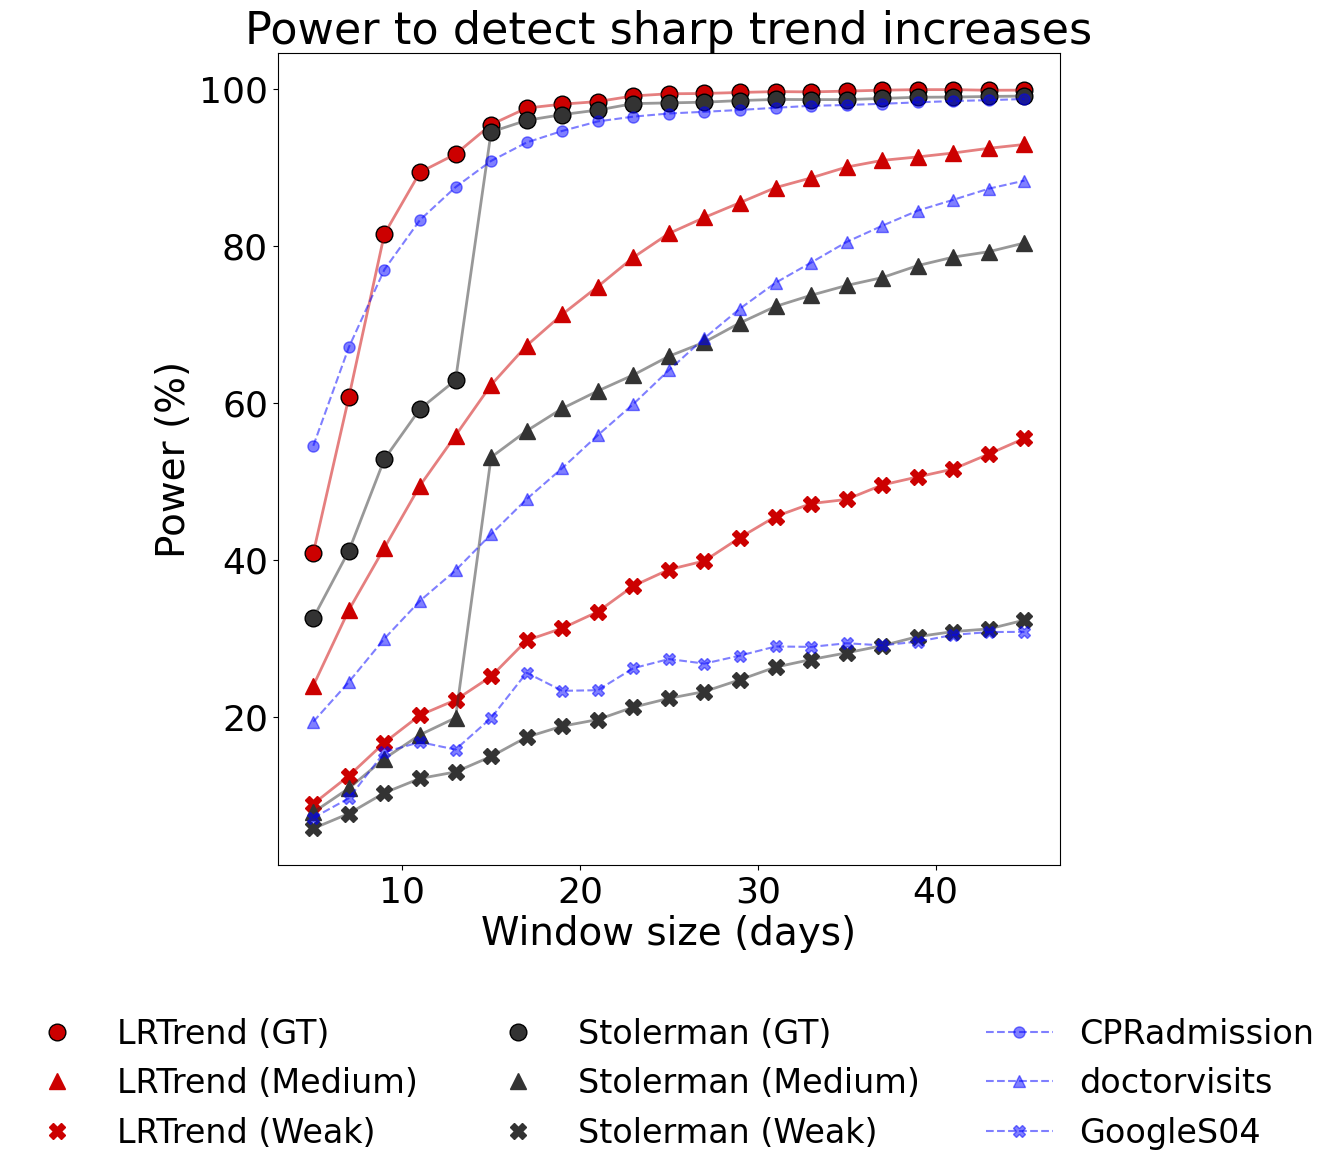

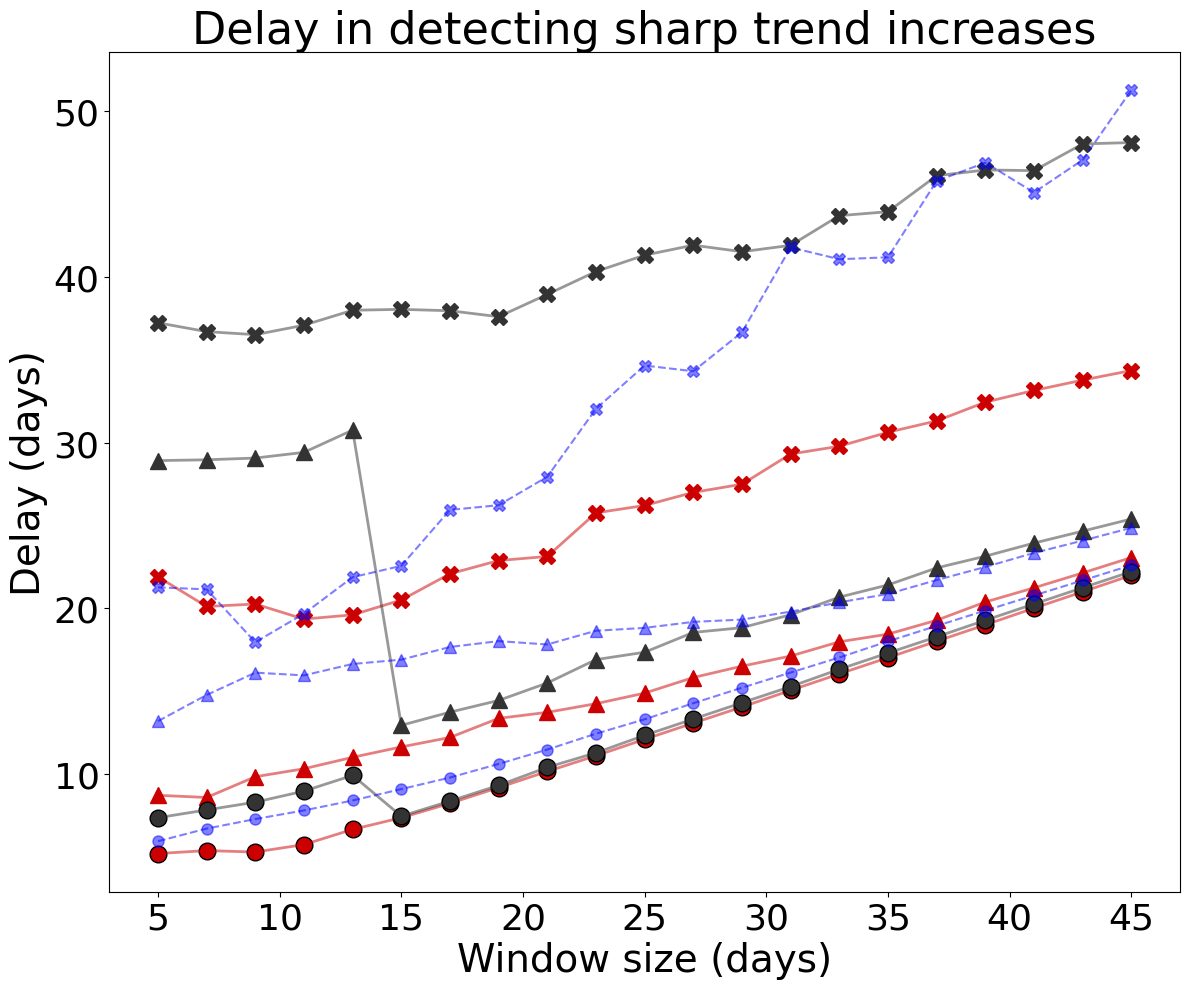

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define streams in the desired order
streams_order = [
    '0_Stouffer', '1_Stouffer', '2_Stouffer',
    '0_Stolerman', '1_Stolerman', '2_Stolerman',
    'CPRadmission', 'doctorvisits', 'GoogleS04'
]

# Human-friendly labels
label_map = {
    '0_Stouffer':   'LRTrend (GT)',
    '1_Stouffer':   'LRTrend (Medium)',
    '2_Stouffer':   'LRTrend (Weak)',
    '0_Stolerman':  'Stolerman (GT)',
    '1_Stolerman':  'Stolerman (Medium)',
    '2_Stolerman':  'Stolerman (Weak)',
    'CPRadmission': 'CPRadmission',
    'doctorvisits': 'doctorvisits',
    'GoogleS04':    'GoogleS04',
}

# Custom colors
color_map = {
    '0_Stouffer':   '#cc0000',
    '1_Stouffer':   '#cc0000',
    '2_Stouffer':   '#cc0000',
    '0_Stolerman':  '#333333',
    '1_Stolerman':  '#333333',
    '2_Stolerman':  '#333333',
    # others default to blue
    'CPRadmission': 'blue',
    'doctorvisits': 'blue',
    'GoogleS04':    'blue',
}

# Marker per group
marker_map = {
    '0': 'o',   # circle
    '1': '^',   # triangle
    '2': 'X',   # x-mark
    'CPRadmission': 'o',   # circle
    'doctorvisits': '^',   # triangle
    'GoogleS04': 'X',   # x-mark
}
# Plot styling
plt.rcParams.update({
    'xtick.labelsize': 26,
    'ytick.labelsize': 26,
    'axes.labelsize': 28
})

# --- Power Plot ---
plt.figure(figsize=(12, 12))
for stream in streams_order:
    ws = sorted(data[stream].keys())
    y = [data[stream][w]['power'] for w in ws]

    if stream in {'CPRadmission', 'doctorvisits', 'GoogleS04'}:
        plt.plot(
            ws, y,
            linestyle='--',
            marker=marker_map[stream],
            color=color_map[stream],
            markersize=8,
            alpha=0.5,
            label=label_map[stream]
        )
    else:
        grp = stream.split('_')[0]
        m = marker_map[grp]
        plt.plot(
            ws, y,
            linestyle='None',
            marker=m,
            markersize=12,
            markerfacecolor=color_map[stream],
            markeredgecolor='black' if grp == '0' else color_map[stream],
            label=label_map[stream]
        )
        plt.plot(ws, y, color=color_map[stream], linewidth=2, alpha=0.5)

plt.xlabel("Window size (days)")
plt.ylabel("Power (%)")
plt.title("Power to detect sharp trend increases", fontsize=32)
handles, labels = plt.gca().get_legend_handles_labels()

# Define the exact order of labels
legend_order = [
    'LRTrend (GT)', 'LRTrend (Medium)', 'LRTrend (Weak)',
    'Stolerman (GT)', 'Stolerman (Medium)', 'Stolerman (Weak)',
    'CPRadmission', 'doctorvisits', 'GoogleS04'
]

# Reorder handles and labels accordingly
ordered = [(l, h) for l, h in zip(labels, handles) if l in legend_order]
ordered.sort(key=lambda x: legend_order.index(x[0]))
labels_ordered, handles_ordered = zip(*ordered)

# Apply legend with 3 columns
plt.legend(
    handles_ordered,
    labels_ordered,
    fontsize=24,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)
plt.grid(False)
plt.tight_layout()
plt.savefig('gt_3_multi_power_markers.png', dpi=300)
plt.show()

# --- Delay Plot ---
plt.figure(figsize=(12, 10))
for stream in streams_order:
    ws = sorted(data[stream].keys())
    y = [data[stream][w]['delay'] + 0.5*(w-1) for w in ws]

    if stream in {'CPRadmission', 'doctorvisits', 'GoogleS04'}:
        plt.plot(
            ws, y,
            linestyle='--',
            marker=marker_map[stream],
            color=color_map[stream],
            markersize=8,
            alpha=0.5,
            label=label_map[stream]
        )
    else:
        grp = stream.split('_')[0]
        m = marker_map[grp]
        plt.plot(
            ws, y,
            linestyle='None',
            marker=m,
            markersize=12,
            markerfacecolor=color_map[stream],
            markeredgecolor='black' if grp == '0' else color_map[stream],
            label=label_map[stream]
        )
        plt.plot(ws, y, color=color_map[stream], linewidth=2, alpha=0.5)

plt.xlabel("Window size (days)")
plt.ylabel("Delay (days)")
plt.title("Delay in detecting sharp trend increases", fontsize=32)
#plt.legend(fontsize=16, loc='best')
plt.grid(False)
plt.tight_layout()
plt.savefig('gt_3_multi_delay_markers.png', dpi=300)
plt.show()


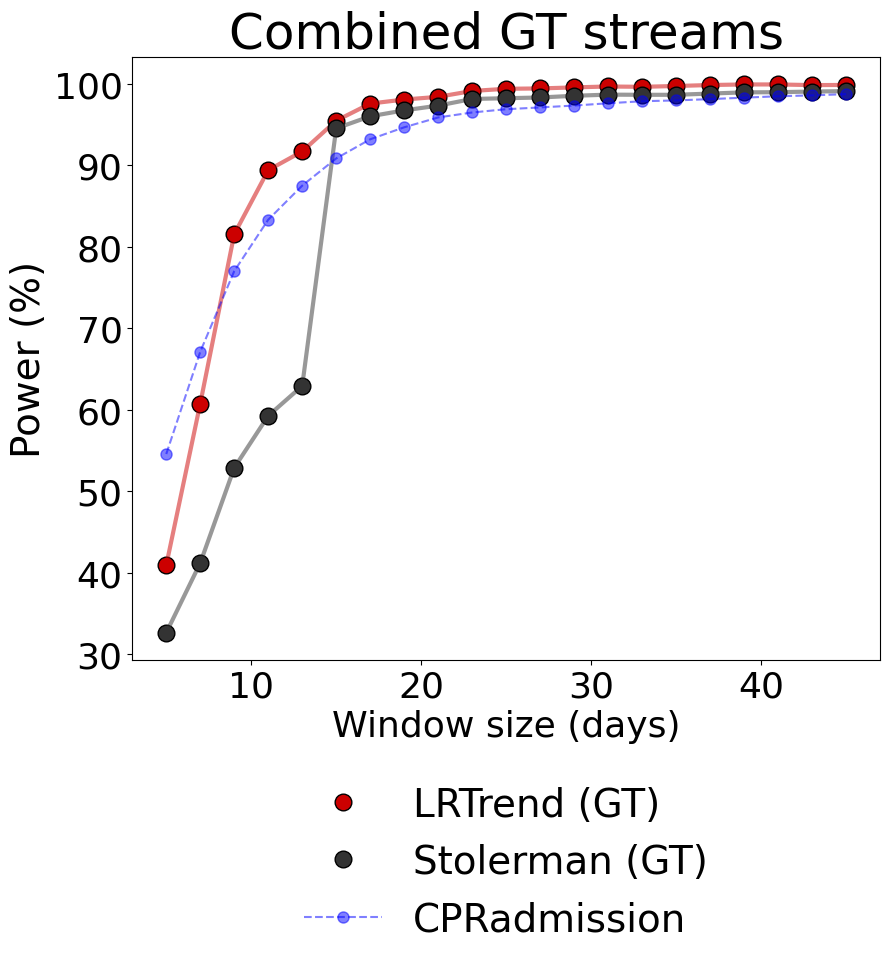

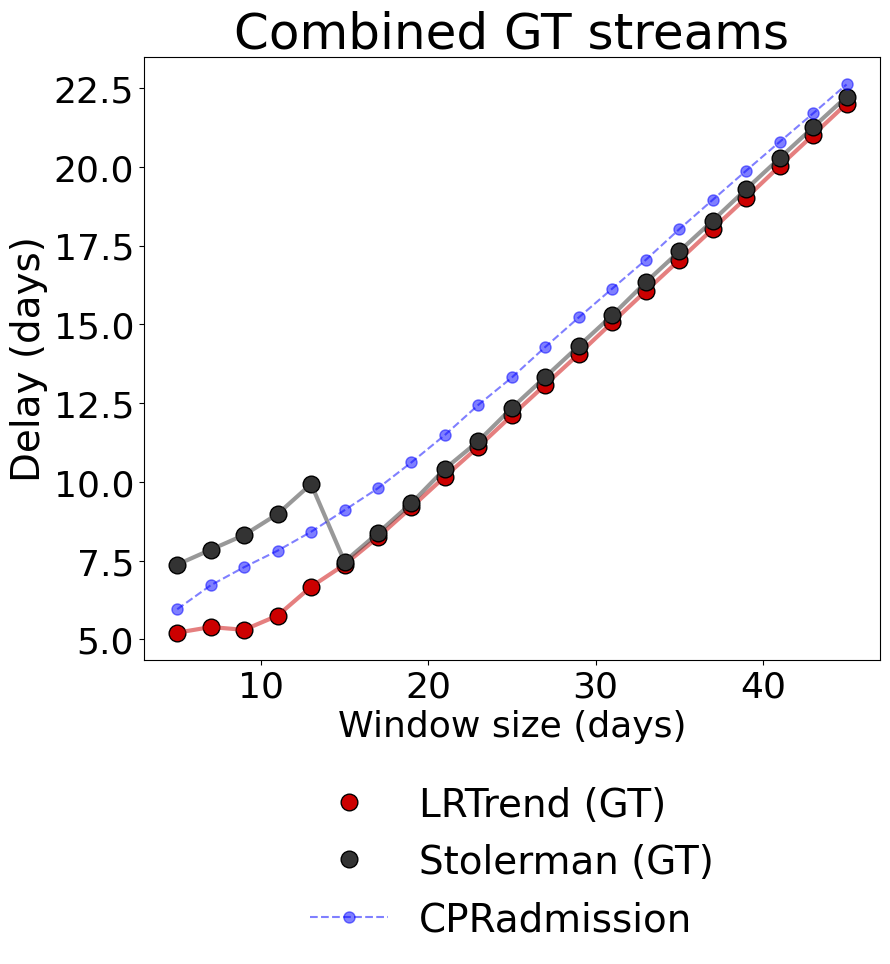

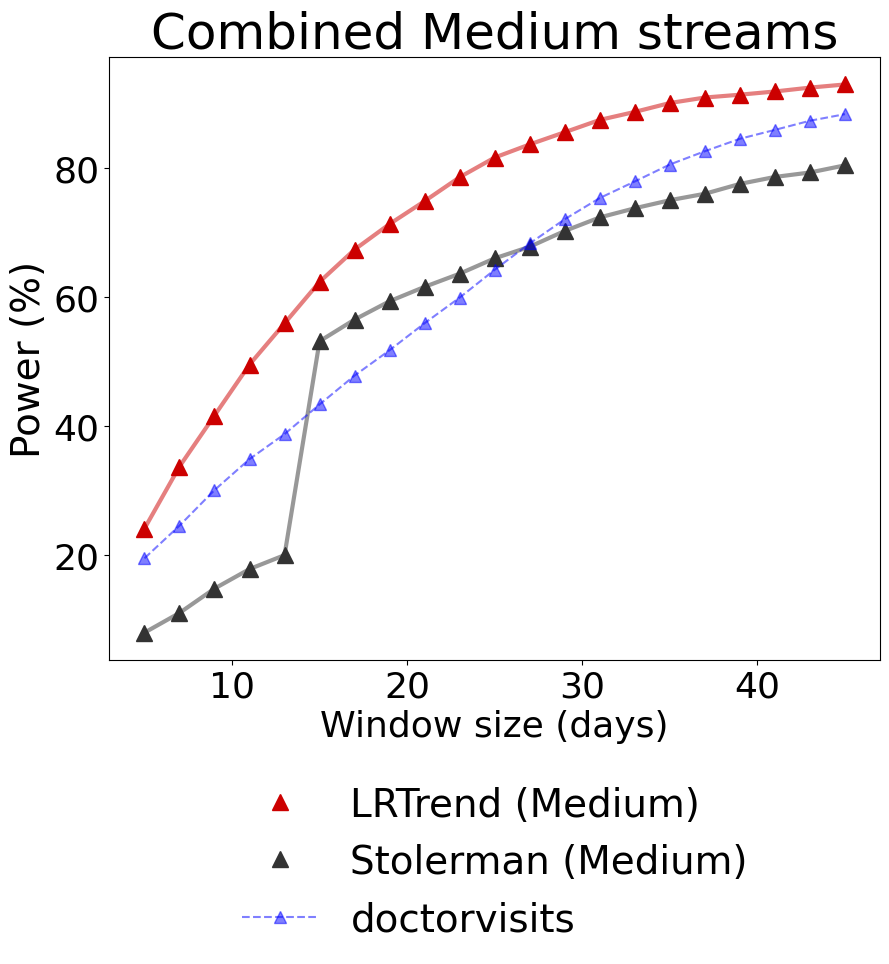

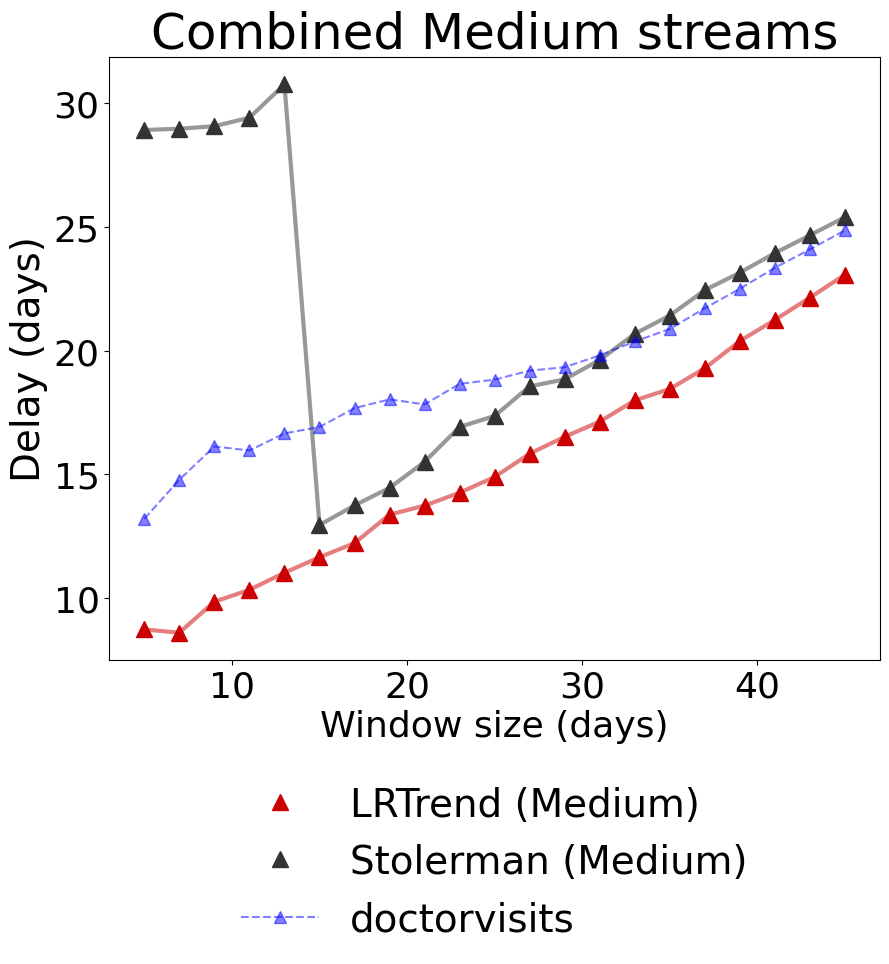

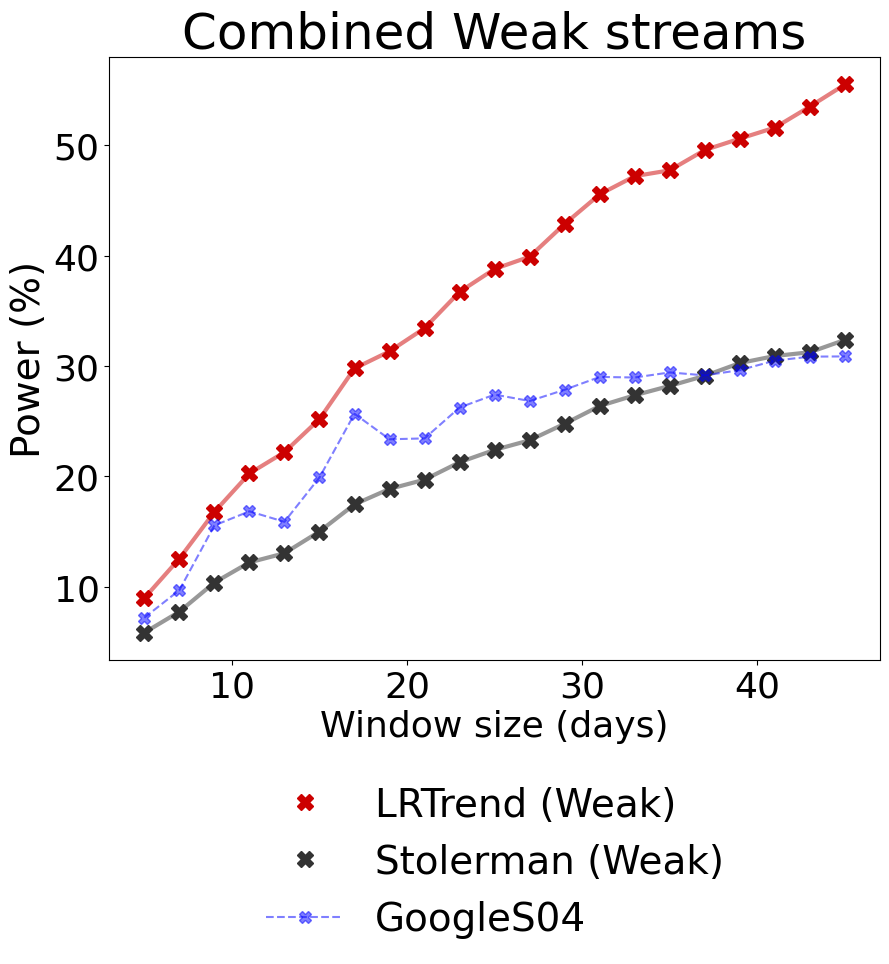

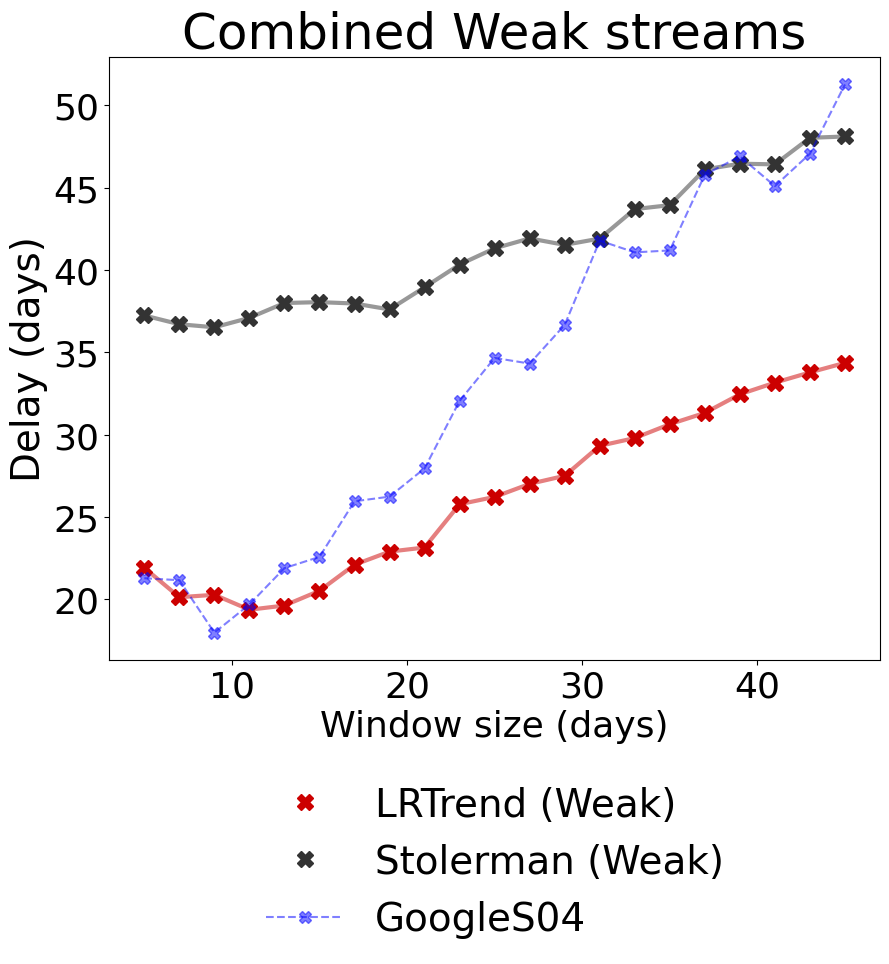

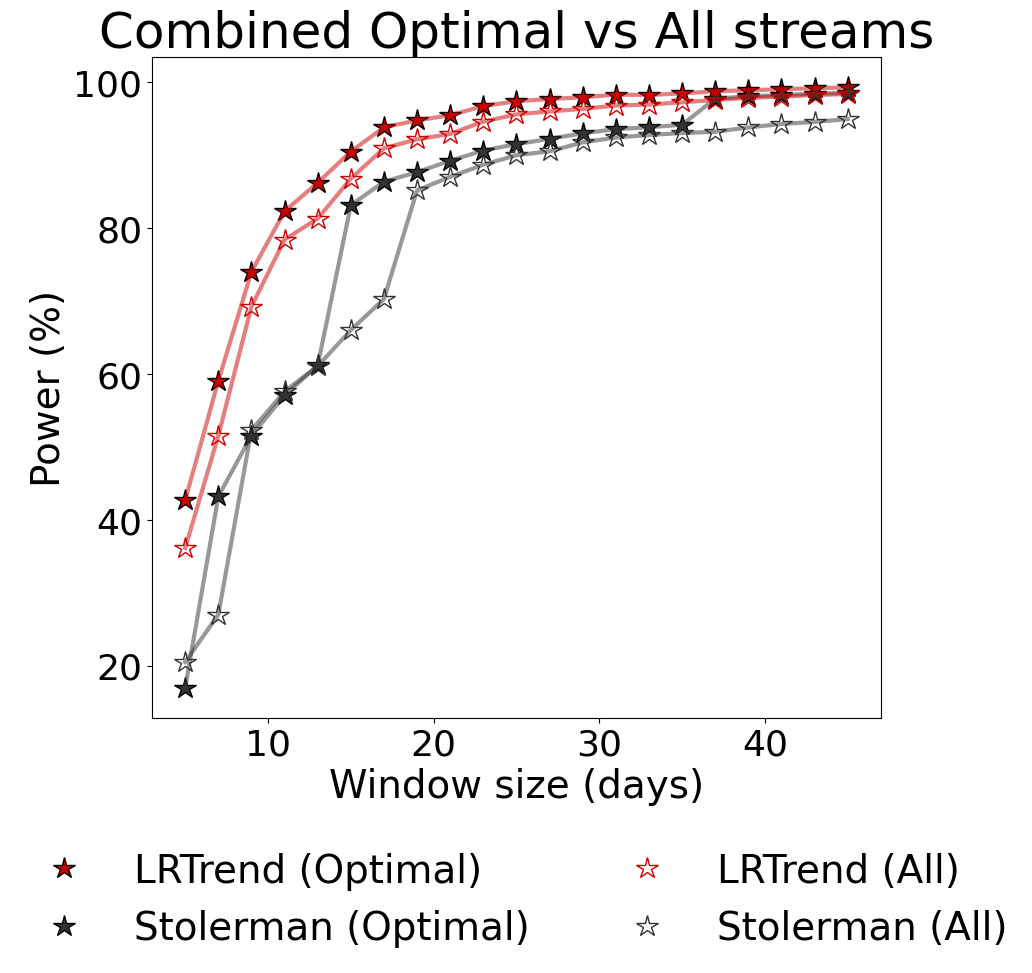

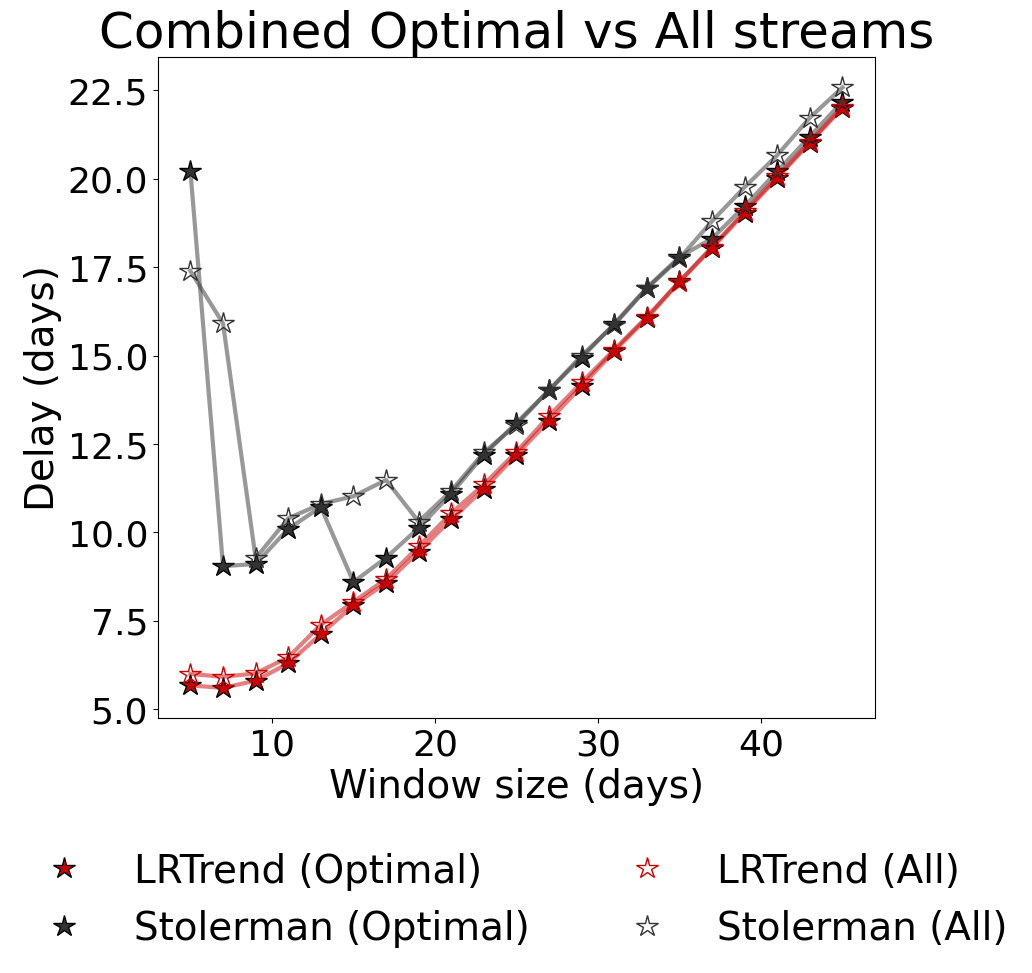

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Define streams in the desired order (now includes Optimal and All)
streams_order = [
    '0_Stouffer', '1_Stouffer', '2_Stouffer', '3_Stouffer', '4_Stouffer',
    '0_Stolerman', '1_Stolerman', '2_Stolerman', '3_Stolerman', '4_Stolerman',
    'CPRadmission', 'doctorvisits', 'GoogleS04'
]

# Human-friendly labels (added Optimal & All)
label_map = {
    '0_Stouffer':   'LRTrend (GT)',
    '1_Stouffer':   'LRTrend (Medium)',
    '2_Stouffer':   'LRTrend (Weak)',
    '3_Stouffer':   'LRTrend (Optimal)',
    '4_Stouffer':   'LRTrend (All)',
    '0_Stolerman':  'Stolerman (GT)',
    '1_Stolerman':  'Stolerman (Medium)',
    '2_Stolerman':  'Stolerman (Weak)',
    '3_Stolerman':  'Stolerman (Optimal)',
    '4_Stolerman':  'Stolerman (All)',
    'CPRadmission': 'CPRadmission',
    'doctorvisits': 'doctorvisits',
    'GoogleS04':    'GoogleS04',
}

# Custom colors – keep family colours consistent
color_map = {
    # LRTrend / Stouffer – all shades of red
    '0_Stouffer':   '#cc0000',
    '1_Stouffer':   '#cc0000',
    '2_Stouffer':   '#cc0000',
    '3_Stouffer':   '#cc0000',
    '4_Stouffer':   '#cc0000',
    # Stolerman – greys
    '0_Stolerman':  '#333333',
    '1_Stolerman':  '#333333',
    '2_Stolerman':  '#333333',
    '3_Stolerman':  '#333333',
    '4_Stolerman':  '#333333',
    # baselines
    'CPRadmission': 'blue',
    'doctorvisits': 'blue',
    'GoogleS04':    'blue',
}

# Marker per group (updated to use filled and hollow star approach)
marker_map = {
    '0': 'o',   # circle – GT
    '1': '^',   # triangle – Medium
    '2': 'X',   # X-mark – Weak
    '3': '*',   # filled star – Optimal
    '4': '*',   # hollow star – All (same marker, but with facecolor='none')
    'CPRadmission': 'o',   # circle
    'doctorvisits': '^',   # triangle
    'GoogleS04': 'X',      # X-mark
}

# Plot styling
plt.rcParams.update({
    'xtick.labelsize': 26,
    'ytick.labelsize': 26,
    'axes.labelsize': 28
})

# Existing GT / Medium / Weak machinery
group_to_prefix = {
    'GT': '0',
    'Medium': '1',
    'Weak': '2'
}

baseline_map = {
    'GT': 'CPRadmission',
    'Medium': 'doctorvisits',
    'Weak': 'GoogleS04'
}

def plot_metric_group(metric, group_name, prefix):
    """
    metric: 'power' or 'delay'
    group_name: 'GT', 'Medium', or 'Weak'
    prefix: '0', '1', or '2' corresponding to that group
    """
    group_streams = [f'{prefix}_Stouffer', f'{prefix}_Stolerman']
    baseline_stream = baseline_map[group_name]
    streams = group_streams + [baseline_stream]

    fig, ax = plt.subplots(figsize=(9, 10))

    for stream in streams:
        ws = sorted(data[stream].keys())
        if metric == 'power':
            y = [data[stream][w]['power'] for w in ws]
        else:  # delay with adjustment
            y = [data[stream][w]['delay'] + 0.5 * (w - 1) for w in ws]

        if stream == baseline_stream:
            ax.plot(
                ws, y,
                linestyle='--',
                marker=marker_map[stream],
                color=color_map[stream],
                markersize=8,
                alpha=0.5,
                label=label_map[stream]
            )
        else:
            grp = stream.split('_')[0]  # '0', '1', '2'
            m = marker_map[grp]
            facecolor = 'none' if grp == '4' else color_map[stream]
            ax.plot(
                ws, y,
                linestyle='None',
                marker=m,
                markersize=12,
                markerfacecolor=facecolor,
                markeredgecolor='black' if grp == '0' else color_map[stream],
                label=label_map[stream]
            )
            ax.plot(ws, y, color=color_map[stream], linewidth=3, alpha=0.5)

    ax.set_xlabel("Window size (days)", fontsize=26)
    if metric == 'power':
        ax.set_ylabel("Power (%)")
        ax.set_title(f"Combined {group_name} streams", fontsize=36)
    else:
        ax.set_ylabel("Delay (days)")
        ax.set_title(f"Combined {group_name} streams", fontsize=36)

    # Legend order: LRTrend, Stolerman, then baseline
    legend_order = [
        f"LRTrend ({group_name})",
        f"Stolerman ({group_name})",
        label_map[baseline_stream]
    ]
    handles, labels = ax.get_legend_handles_labels()
    ordered = [(l, h) for l, h in zip(labels, handles) if l in legend_order]
    ordered.sort(key=lambda x: legend_order.index(x[0]))
    if ordered:
        labels_ordered, handles_ordered = zip(*ordered)
        ax.legend(
            handles_ordered,
            labels_ordered,
            fontsize=28,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.15),
            ncol=1,
            frameon=False
        )

    ax.grid(False)
    plt.tight_layout()

    fname = f"{group_name.lower()}_{metric}_multi_markers.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    return fname

# NEW: Optimal vs All plot (no baseline)
def plot_optimal_all(metric):
    """Plot 3/4 Stouffer & Stolerman together for Optimal vs All."""
    streams = ['3_Stouffer', '3_Stolerman', '4_Stouffer', '4_Stolerman']

    fig, ax = plt.subplots(figsize=(10, 10))

    for stream in streams:
        ws = sorted(data[stream].keys())
        if metric == 'power':
            y = [data[stream][w]['power'] for w in ws]
        else:
            y = [data[stream][w]['delay'] + 0.5 * (w - 1) for w in ws]

        grp = stream.split('_')[0]  # '3' or '4'
        m = marker_map[grp]
        facecolor = 'none' if grp == '4' else color_map[stream]
        ax.plot(
            ws, y,
            linestyle='None',
            marker=m,
            markersize=16,
            markerfacecolor=facecolor,
            markeredgecolor='black' if grp == '3' else color_map[stream],
            label=label_map[stream]
        )
        ax.plot(ws, y, color=color_map[stream], linewidth=3, alpha=0.5)

    ax.set_xlabel("Window size (days)")
    if metric == 'power':
        ax.set_ylabel("Power (%)")
        ax.set_title("Combined Optimal vs All streams", fontsize=36)
    else:
        ax.set_ylabel("Delay (days)")
        ax.set_title("Combined Optimal vs All streams", fontsize=36)

    legend_order = [
        'LRTrend (Optimal)',
        'Stolerman (Optimal)',
        'LRTrend (All)',
        'Stolerman (All)'
    ]
    handles, labels = ax.get_legend_handles_labels()
    ordered = [(l, h) for l, h in zip(labels, handles) if l in legend_order]
    ordered.sort(key=lambda x: legend_order.index(x[0]))
    if ordered:
        labels_ordered, handles_ordered = zip(*ordered)
        ax.legend(
            handles_ordered,
            labels_ordered,
            fontsize=28,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.15),
            ncol=2,
            frameon=False
        )

    ax.grid(False)
    plt.tight_layout()

    fname = f"optimal_all_{metric}_multi_markers.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    return fname

# Generate plots
filenames = []
for group_name, prefix in group_to_prefix.items():
    filenames.append(plot_metric_group('power', group_name, prefix))
    filenames.append(plot_metric_group('delay', group_name, prefix))

# Additional Optimal vs All plots
filenames.append(plot_optimal_all('power'))
filenames.append(plot_optimal_all('delay'))

# filenames list now also contains the two new images at the end


In [5]:
import numpy as np

# inverse of your group_to_prefix mapping
prefix_to_group = {'0': 'GT', '1': 'Medium', '2': 'Weak', '3': 'Optimal', '4': 'All'}

# your baseline mapping
baseline_map = {
    'GT': 'CPRadmission',
    'Medium': 'doctorvisits',
    'Weak': 'GoogleS04'
}

def compute_auc(y, x):
    """Integrate via trapezoid rule."""
    return np.trapz(y, x)

def auc_improvements_with_baseline(data, metric='power'):
    """
    Returns a dict of:
      results[prefix] = {
        'AUC_Stouffer': ...,
        'AUC_Stolerman': ...,
        'Pct_vs_Stolerman': ...,
        # only for prefixes 0,1,2:
        'AUC_Baseline': ...,
        'Pct_vs_Baseline': ...
      }
    and prints a summary.
    """
    prefixes = ['0','1','2','3','4']
    results = {}
    for p in prefixes:
        grp = prefix_to_group[p]
        stou = f"{p}_Stouffer"
        stol = f"{p}_Stolerman"

        # common x-axis
        ws = np.array(sorted(data[stou].keys()))

        if metric == 'power':
            y_stou = np.array([data[stou][w]['power'] for w in ws])
            y_stol = np.array([data[stol][w]['power'] for w in ws])
        else:
            y_stou = np.array([data[stou][w]['delay'] + 0.5*(w-1) for w in ws])
            y_stol = np.array([data[stol][w]['delay']  + 0.5*(w-1) for w in ws])

        auc_stou = compute_auc(y_stou, ws)
        auc_stol = compute_auc(y_stol, ws)

        pct_vs_stol = (auc_stou - auc_stol) / auc_stol * 100 if auc_stol != 0 else np.nan

        entry = {
            'AUC_Stouffer':      auc_stou,
            'AUC_Stolerman':     auc_stol,
            'Pct_vs_Stolerman':  pct_vs_stol
        }

        print(f"[{grp}] Stouffer vs Stolerman: "
              f"AUCₛₜₒᵤ = {auc_stou:.2f}, AUCₛₜₒₗ = {auc_stol:.2f}, ↑{pct_vs_stol:.1f}%")

        # for GT/Medium/Weak also compare to baseline
        if p in ['0','1','2']:
            base_stream = baseline_map[grp]
            # assume baseline only has same ws keys
            y_base = np.array([
                data[base_stream][w]['power']    if metric=='power'
                else data[base_stream][w]['delay'] + 0.5*(w-1)
                for w in ws
            ])
            auc_base = compute_auc(y_base, ws)
            pct_vs_base = (auc_stou - auc_base) / auc_base * 100 if auc_base != 0 else np.nan

            entry.update({
                'AUC_Baseline':     auc_base,
                'Pct_vs_Baseline':  pct_vs_base
            })

            print(f"         Stouffer vs {base_stream}: "
                  f"AUCₛₜₒᵤ = {auc_stou:.2f}, AUC₍base₎ = {auc_base:.2f}, ↑{pct_vs_base:.1f}%")

        results[p] = entry

    return results

improvements = auc_improvements_with_baseline(data, metric='power')
improvements_delay = auc_improvements_with_baseline(data, metric='delay')


[GT] Stouffer vs Stolerman: AUCₛₜₒᵤ = 3758.70, AUCₛₜₒₗ = 3503.29, ↑7.3%
         Stouffer vs CPRadmission: AUCₛₜₒᵤ = 3758.70, AUC₍base₎ = 3681.67, ↑2.1%
[Medium] Stouffer vs Stolerman: AUCₛₜₒᵤ = 2953.74, AUCₛₜₒₗ = 2275.51, ↑29.8%
         Stouffer vs doctorvisits: AUCₛₜₒᵤ = 2953.74, AUC₍base₎ = 2437.81, ↑21.2%
[Weak] Stouffer vs Stolerman: AUCₛₜₒᵤ = 1455.34, AUCₛₜₒₗ = 856.88, ↑69.8%
         Stouffer vs GoogleS04: AUCₛₜₒᵤ = 1455.34, AUC₍base₎ = 969.96, ↑50.0%
[Optimal] Stouffer vs Stolerman: AUCₛₜₒᵤ = 3656.29, AUCₛₜₒₗ = 3317.88, ↑10.2%
[All] Stouffer vs Stolerman: AUCₛₜₒᵤ = 3552.24, AUCₛₜₒₗ = 3159.17, ↑12.4%
[GT] Stouffer vs Stolerman: AUCₛₜₒᵤ = 496.56, AUCₛₜₒₗ = 529.55, ↑-6.2%
         Stouffer vs CPRadmission: AUCₛₜₒᵤ = 496.56, AUC₍base₎ = 546.58, ↑-9.2%
[Medium] Stouffer vs Stolerman: AUCₛₜₒᵤ = 609.62, AUCₛₜₒₗ = 859.33, ↑-29.1%
         Stouffer vs doctorvisits: AUCₛₜₒᵤ = 609.62, AUC₍base₎ = 763.48, ↑-20.2%
[Weak] Stouffer vs Stolerman: AUCₛₜₒᵤ = 1046.18, AUCₛₜₒₗ = 1650.53, ↑-36.6%
